
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_1072461/3381654816.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


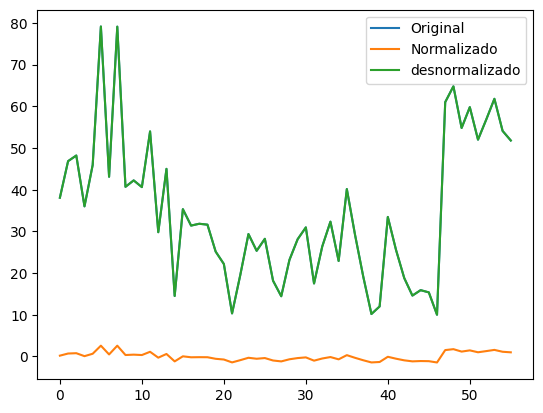

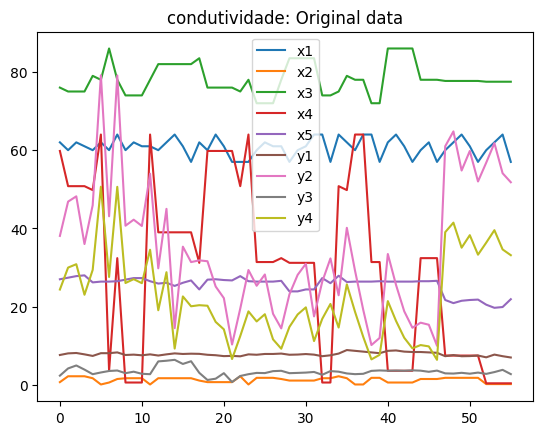

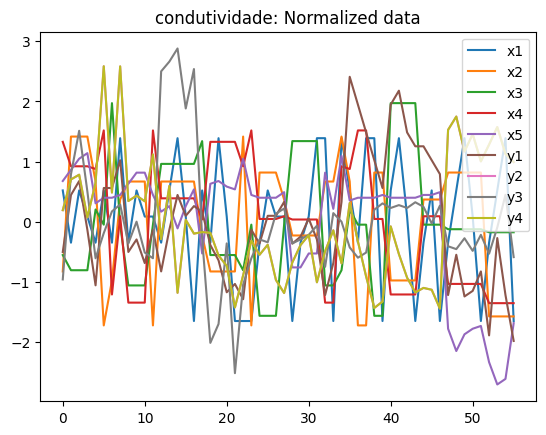

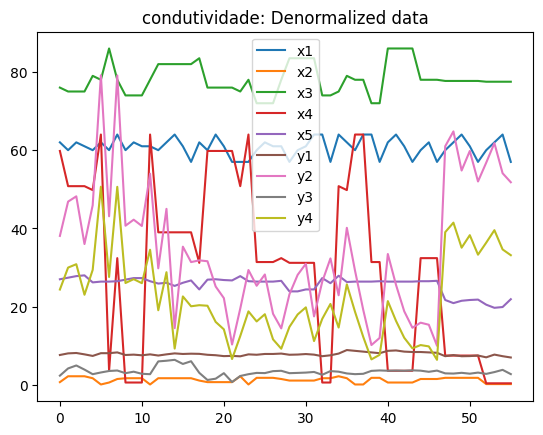

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y2"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y2")
test_out_scaler()
show_norm(label="condutividade")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-05 17:55:11.092284: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 17:55:11.137634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 17:55:11.137675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 17:55:11.139042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 17:55:11.146733: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 17:55:11.148037: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[15,2], [15,5], [15,7], [20,2], [20,5], [20, 7], [20, 10], [30, 5], [30, 10], [30, 15]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[15, 2], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.530911680999452
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.3815599999998085
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.34179728599974624
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.3998033610005223
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.2787007850001828
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.4399557830001868
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_0] | 7 ++++++++++

Elapsed time:  0.5600884799996493
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_0] | 14 ++++++++++++++++++
Elapsed time:  0.31989500500003487
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 15 ++++++++++++++++++
Elapsed time:  4.408158333999381
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_0] | 16 ++++++++++++++++++
Elapsed time:  0.043102966000333254
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [1_0] | 17 ++++++++++++++++++
Elapsed time:  0.02787965900006384
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 18 ++++++++++++++++++
Elapsed time:  0.028143350999926042
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 19 ++++++++++++++++++
Elapsed time:  0.04003839799952402
Stopped at epoch:  0
1/1 [==============================] - 0s 22m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_2_7,0.802878,0.340749,-0.296868,0.519353,58.039609,185.943056,145.715351,167.012361
model_3_2_0,0.805087,0.587829,0.595765,0.761364,57.389217,116.253529,45.419588,82.919923
model_3_2_6,0.806338,0.358214,-0.175603,0.545311,57.020717,181.017100,132.090145,157.992657
model_3_2_5,0.809729,0.381734,-0.047397,0.574928,56.022384,174.383058,117.684962,147.701618
model_3_2_1,0.812053,0.539736,0.475732,0.722431,55.338113,129.818356,58.906425,96.448064
model_3_2_4,0.812702,0.412139,0.085071,0.608152,55.146823,165.807424,102.800919,136.157304
model_3_2_3,0.814675,0.449460,0.218411,0.644480,54.566088,155.280868,87.818856,123.534044
model_3_2_2,0.814814,0.492677,0.349424,0.682988,54.524973,143.091362,73.098339,110.153461


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Elapsed time:  0.28727608200006216
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Elapsed time:  0.25843087900011597
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Elapsed time:  0.2030465589996311
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Elapsed time:  0.1742506800001138
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Elapsed time:  0.2613301430001229
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Elapsed time:  0.26542534100008197
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Elapsed time:  0.224777209

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_3_0,0.806970,0.114932,0.798588,0.606227,56.834520,150.846216,85.407763,120.051633
model_3_3_1,0.819529,0.110792,0.797310,0.604165,53.136900,151.551716,85.949925,120.680290
model_3_3_2,0.828968,0.104487,0.794136,0.600222,50.357564,152.626387,87.295641,121.882512
model_3_3_3,0.835964,0.096744,0.789655,0.594997,48.297691,153.946111,89.195838,123.475400
model_3_3_4,0.841050,0.088115,0.784302,0.588940,46.800305,155.416747,91.465710,125.322154
model_3_3_24,0.841391,-0.033311,0.698457,0.496814,46.699859,176.111845,127.868125,153.408917
model_3_3_23,0.841907,-0.030761,0.700312,0.498783,46.547984,175.677271,127.081563,152.808711
model_3_3_22,0.842462,-0.027952,0.702357,0.500953,46.384600,175.198492,126.214417,152.147164
model_3_3_21,0.843056,-0.024860,0.704609,0.503342,46.209705,174.671548,125.259405,151.418767
model_3_3_20,0.843688,-0.021461,0.707086,0.505970,46.023586,174.092176,124.208895,150.617671


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Elapsed time:  0.18235568900036014
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Elapsed time:  0.21979807400020945
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Elapsed time:  0.18580018499960715
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Elapsed time:  0.18709677500010002
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Elapsed time:  0.24640497000018513
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Elapsed time:  0.18633098900045297
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Elapsed time:  0.252333

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_4_0,0.863406,0.945609,0.642688,0.870987,40.217865,15.164316,44.834819,29.126897
model_3_4_1,0.878993,0.945363,0.566989,0.851028,35.628522,15.232758,54.333345,33.633026
model_3_4_24,0.888638,0.911945,-0.597526,0.524605,32.788828,24.549841,200.454460,107.328467
model_3_4_23,0.889500,0.912501,-0.582063,0.529013,32.534980,24.394725,198.514108,106.333241
model_3_4_2,0.889939,0.944268,0.481059,0.827837,32.405743,15.538101,65.115646,38.868727
model_3_4_22,0.890435,0.913115,-0.564914,0.533900,32.259571,24.223486,196.362342,105.229995
model_3_4_21,0.891447,0.913794,-0.545904,0.539315,31.961765,24.034414,193.976994,104.007397
model_3_4_20,0.892536,0.914542,-0.524836,0.545315,31.640948,23.825714,191.333411,102.652847
model_3_4_19,0.893705,0.915369,-0.501494,0.551961,31.296855,23.595111,188.404473,101.152457
model_3_4_18,0.894952,0.916284,-0.475645,0.559319,30.929777,23.340183,185.160973,99.491163


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.1886955649997617
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Elapsed time:  0.2330663419998018
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Elapsed time:  0.2775404949998119
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Elapsed time:  0.18208238199986226
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Elapsed time:  0.25691112599997723
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Elapsed time:  0.19380529499994736
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Elapsed time:  0.225586211

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.901949,0.721520,0.938371,0.780480,28.869565,98.913662,8.600493,56.413347
model_3_5_1,0.911961,0.736742,0.930251,0.789543,25.921604,93.506896,9.733661,54.084214
model_3_5_2,0.919460,0.747504,0.919415,0.794649,23.713789,89.684385,11.245821,52.772122
model_3_5_3,0.925038,0.754938,0.907148,0.796954,22.071337,87.043725,12.957668,52.179696
model_3_5_4,0.929154,0.759978,0.894142,0.797318,20.859523,85.253676,14.772762,52.086185
model_3_5_5,0.932163,0.763388,0.880743,0.796389,19.973498,84.042666,16.642556,52.324984
model_3_5_24,0.934258,0.763193,0.710839,0.752828,19.356701,84.111795,40.353017,63.519417
model_3_5_6,0.934339,0.765753,0.867133,0.794642,19.332761,83.202561,18.541827,52.773982
model_3_5_23,0.934562,0.763734,0.714652,0.754199,19.267151,83.919465,39.820912,63.167196
model_3_5_22,0.934885,0.764309,0.718856,0.755694,19.171988,83.715301,39.234288,62.783050


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.218724865000695
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.20364006999989215
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.217976130000352
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.19745796200004406
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.19055403499987733
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.26358540799992625
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.2432727299

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.939865,0.965418,0.719186,0.886497,17.705837,11.971164,57.474185,33.384349
model_3_6_1,0.944041,0.963691,0.715028,0.884059,16.476110,12.569126,58.325171,34.101384
model_3_6_2,0.947112,0.961229,0.710631,0.881085,15.572096,13.421547,59.225230,34.976213
model_3_6_3,0.949331,0.958331,0.706151,0.877813,14.918836,14.424577,60.142057,35.938674
model_3_6_24,0.949887,0.917758,0.653476,0.835283,14.755070,28.469711,70.923076,48.447769
model_3_6_23,0.950073,0.918468,0.654382,0.836022,14.700292,28.223990,70.737720,48.230439
model_3_6_22,0.950273,0.919253,0.655382,0.836839,14.641202,27.952361,70.532939,47.990262
model_3_6_21,0.950489,0.920120,0.656487,0.837741,14.577740,27.652293,70.306738,47.724985
model_3_6_20,0.950719,0.921076,0.657706,0.838736,14.509943,27.321120,70.057255,47.432239
model_3_6_4,0.950897,0.955215,0.701704,0.874415,14.457745,15.503305,61.052363,36.938156


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.2727874519996476
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.2807921339999666
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.24983603900000162
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.32249694599977374
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.23083251499974722
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.23571684499984258
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.25801948

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_4,0.811952,0.962820,-2.084099,0.529675,55.367811,21.355023,342.785627,172.616483
model_3_7_3,0.856115,0.968982,-1.259225,0.652334,42.364687,17.816042,251.104136,127.598673
model_3_7_2,0.898503,0.974295,-0.454999,0.771348,29.884226,14.764377,161.717454,83.918775
model_3_7_1,0.936135,0.980241,0.273754,0.880130,18.804178,11.349166,80.719444,43.993994
model_3_7_0,0.949899,0.983833,0.629010,0.933735,14.751401,9.285593,41.234106,24.320188


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.7852739879999717
Stopped at epoch:  19
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.24535796600048343
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.23541450799984887
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.2188151199998174
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.23074619900035032
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.21061173399994004
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.2484719

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.958844,0.893378,0.971188,0.951558,12.117663,17.925588,13.554010,15.868387
model_3_8_1,0.963398,0.892494,0.971035,0.951215,10.776947,18.074348,13.625716,15.980867
model_3_8_2,0.967054,0.891519,0.970843,0.950820,9.700432,18.238143,13.716329,16.110231
model_3_8_3,0.969985,0.890487,0.970624,0.950392,8.837330,18.411649,13.819079,16.250442
model_3_8_4,0.972332,0.889425,0.970391,0.949945,8.146481,18.590281,13.928953,16.396712
model_3_8_5,0.974206,0.888352,0.970150,0.949491,7.594690,18.770595,14.042070,16.545413
model_3_8_6,0.975699,0.887287,0.969909,0.949039,7.155014,18.949645,14.155412,16.693547
model_3_8_7,0.976885,0.886242,0.969672,0.948595,6.805714,19.125327,14.266871,16.839000
model_3_8_8,0.977825,0.885228,0.969443,0.948164,6.529120,19.295832,14.374827,16.980065
model_3_8_9,0.978566,0.884253,0.969223,0.947751,6.310952,19.459829,14.478209,17.115560


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.22633597399999417
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.24577166300059616
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.2755100529993797
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.2975729820000197
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.23179923399948166
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.22514831099942967
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.18813056

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.973369,0.974067,0.580323,0.907394,7.840934,10.391181,43.006281,25.739462
model_3_9_23,0.973805,0.974638,0.586998,0.908988,7.712799,10.162255,42.322297,25.296387
model_3_9_22,0.974281,0.975265,0.594359,0.910743,7.572546,9.911186,41.567952,24.808482
model_3_9_21,0.974801,0.975951,0.602467,0.912674,7.419363,9.636272,40.737054,24.271924
model_3_9_20,0.975368,0.976701,0.611392,0.914795,7.252386,9.335703,39.822515,23.682436
model_3_9_19,0.975985,0.977519,0.621200,0.917121,7.070896,9.007845,38.817467,23.035898
model_3_9_18,0.976653,0.978410,0.631964,0.919668,6.874204,8.651051,37.714355,22.327895
model_3_9_17,0.977374,0.979376,0.643760,0.922452,6.661797,8.263798,36.505583,21.554051
model_3_9_16,0.978150,0.980422,0.656661,0.925488,6.433388,7.844847,35.183591,20.710145
model_3_9_15,0.978980,0.981549,0.670740,0.928791,6.188994,7.393338,33.740842,19.792167


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[15, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.5616044620001048
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.26619425600074464
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.17205651099993702
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.2676306499997736
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.36374107700066816
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.3204550680002285
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_2_17,0.800022,0.207608,0.507127,0.313805,58.880514,268.519788,102.648324,190.462599
model_4_2_16,0.805338,0.229287,0.528416,0.335334,57.315069,261.173458,98.214616,184.486965
model_4_2_15,0.811017,0.253750,0.550147,0.358819,55.642959,252.883563,93.688748,177.968343
model_4_2_14,0.817000,0.281076,0.572055,0.384217,53.881499,243.623596,89.126084,170.918872
model_4_2_0,0.821376,0.847848,0.786599,0.826305,52.592903,51.560085,44.444001,48.211348
model_4_2_13,0.823205,0.311264,0.593909,0.411445,52.054394,233.393834,84.574667,163.361295
model_4_2_12,0.829532,0.344243,0.615527,0.440395,50.191651,222.218055,80.072416,155.325983
model_4_2_11,0.835854,0.379882,0.636770,0.470931,48.330261,210.141051,75.648209,146.850314
model_4_2_1,0.838531,0.808140,0.787711,0.801033,47.541878,65.016087,44.212343,55.226089
model_4_2_10,0.842017,0.417990,0.657521,0.502889,46.515713,197.227353,71.326448,137.979845


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Elapsed time:  0.27742055599992455
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Elapsed time:  0.2764563970004019
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Elapsed time:  0.2867213429999538
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Elapsed time:  0.2492778020005062
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Elapsed time:  0.21942755700001726
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Elapsed time:  0.26715323999997054
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Elapsed time:  0.249593569

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_0,0.816732,0.716634,0.964814,0.839784,53.960312,76.875001,9.635987,45.233115
model_4_3_1,0.842753,0.724694,0.962631,0.842888,46.298882,74.688381,10.233854,44.356831
model_4_3_2,0.863329,0.733024,0.953585,0.842996,40.240652,72.428575,12.711362,44.326362
model_4_3_3,0.879852,0.744132,0.938126,0.841590,35.375802,69.415004,16.944802,44.723130
model_4_3_4,0.892711,0.754485,0.918724,0.838001,31.589505,66.606310,22.258288,45.736639
model_4_3_5,0.902367,0.762063,0.897606,0.832216,28.746401,64.550442,28.041722,47.369867
model_4_3_6,0.909449,0.767100,0.875892,0.824866,26.661241,63.183840,33.988394,49.444808
model_4_3_7,0.914517,0.770190,0.854221,0.816546,25.169198,62.345547,39.923226,51.793851
model_4_3_24,0.914777,0.760214,0.632567,0.710290,25.092484,65.052128,100.625518,81.792532
model_4_3_23,0.915462,0.760862,0.638572,0.713361,24.890937,64.876196,98.980912,80.925478


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.2711966679999023
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.2232483299994783
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.2554844939995746
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.20543297400035954
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.21399397299956036
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.4426900739999837
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.2154317610

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_24,0.878719,0.786838,0.260671,0.572745,35.709317,62.523903,179.111386,117.388595
model_4_4_23,0.880030,0.789084,0.269262,0.577580,35.323338,61.865121,177.030107,116.060341
model_4_4_22,0.881481,0.791588,0.278810,0.582956,34.896176,61.130712,174.716927,114.583098
model_4_4_21,0.883085,0.794379,0.289418,0.588936,34.423735,60.311894,172.147151,112.940253
model_4_4_20,0.884858,0.797492,0.301196,0.595583,33.901792,59.398848,169.293598,111.114020
model_4_4_19,0.886814,0.800964,0.314267,0.602968,33.325865,58.380545,166.127190,109.084875
model_4_4_18,0.888969,0.804836,0.328759,0.611170,32.691205,57.244632,162.616225,106.831279
model_4_4_17,0.891340,0.809156,0.344807,0.620271,31.993269,55.977669,158.728415,104.330992
model_4_4_16,0.893941,0.813973,0.362552,0.630356,31.227452,54.564716,154.429384,101.559864
model_4_4_15,0.896786,0.819344,0.382135,0.641517,30.389686,52.989397,149.685317,98.493378


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.3212511510000695
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.18470088300000498
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.30958006599939836
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.2708281690001968
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.2629325810003138
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.24284317000001465
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.189975981

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_24,0.870264,0.879403,0.418871,0.662010,38.198865,30.589007,232.320715,125.521590
model_4_5_23,0.870963,0.880366,0.422174,0.664032,37.993006,30.344633,231.000358,124.770769
model_4_5_22,0.871729,0.881423,0.425846,0.666274,37.767477,30.076731,229.532143,123.938099
model_4_5_21,0.872567,0.882579,0.429930,0.668761,37.520723,29.783421,227.899463,123.014469
model_4_5_20,0.873482,0.883843,0.434472,0.671518,37.251387,29.462905,226.083960,121.990463
model_4_5_19,0.874478,0.885221,0.439522,0.674575,36.958037,29.113345,224.064899,120.855274
model_4_5_18,0.875560,0.886719,0.445138,0.677962,36.639492,28.733246,221.819797,119.597498
model_4_5_17,0.876731,0.888344,0.451382,0.681713,36.294755,28.321110,219.323429,118.204552
model_4_5_16,0.877993,0.890100,0.458325,0.685864,35.923130,27.875696,216.548097,116.662691
model_4_5_15,0.879347,0.891989,0.466041,0.690456,35.524494,27.396501,213.463297,114.957371


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.26034851300028095
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.1883556540005884
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.2198285680005938
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.23996100299973477
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.2321865780004373
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.25954014799935976
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.223564409

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_6_0,0.895212,0.975684,0.994778,0.987225,30.853228,5.436598,2.001513,3.820084
model_4_6_1,0.914770,0.977519,0.994590,0.987838,25.094689,5.026315,2.073623,3.636812
model_4_6_2,0.930271,0.977855,0.993946,0.987583,20.530693,4.951166,2.320304,3.713116
model_4_6_3,0.942594,0.977296,0.993023,0.986805,16.902335,5.076136,2.674185,3.945805
model_4_6_4,0.952386,0.976029,0.991943,0.985652,14.019305,5.359316,3.087943,4.290430
model_4_6_5,0.960149,0.974163,0.990792,0.984219,11.733647,5.776568,3.529226,4.718991
model_4_6_6,0.966282,0.971801,0.989625,0.982580,9.927598,6.304684,3.976472,5.209053
model_4_6_7,0.971109,0.969050,0.988479,0.980800,8.506445,6.919694,4.415631,5.741311
model_4_6_8,0.974888,0.966015,0.987378,0.978935,7.393861,7.598296,4.837883,6.299284
model_4_6_9,0.977828,0.962791,0.986334,0.977028,6.528249,8.319198,5.238056,6.869253


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Elapsed time:  0.3222893069996644
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Elapsed time:  0.28674177799985046
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Elapsed time:  0.22835467899949435
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Elapsed time:  0.25025028200070665
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Elapsed time:  0.27131621500029723
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Elapsed time:  0.283825216999503
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Elapsed time:  0.326617939

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_0,0.991532,0.994228,0.989613,0.992217,2.493373,1.403505,2.472475,1.906557
model_4_7_1,0.992600,0.993353,0.989178,0.991558,2.178946,1.616347,2.576044,2.067972
model_4_7_2,0.993395,0.992458,0.988432,0.990746,1.944882,1.833864,2.753652,2.266708
model_4_7_3,0.993977,0.991571,0.987483,0.989846,1.773345,2.049678,2.979467,2.487222
model_4_7_24,0.994196,0.981815,0.971000,0.977182,1.709040,4.421868,6.902992,5.589452
model_4_7_23,0.994246,0.981980,0.971329,0.977419,1.694276,4.381741,6.824690,5.531362
model_4_7_22,0.994300,0.982163,0.971691,0.977680,1.678384,4.337435,6.738488,5.467340
model_4_7_21,0.994357,0.982364,0.972089,0.977968,1.661359,4.288522,6.643706,5.396846
model_4_7_4,0.994395,0.990707,0.986411,0.988902,1.650329,2.259682,3.234627,2.718477
model_4_7_20,0.994419,0.982585,0.972526,0.978284,1.643222,4.234605,6.539609,5.319316


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.2337277010001344
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.20576733899997635
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.23886751900045056
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.19000156699985382
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.242474626999865
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.1981514139997671
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.3374487199

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_24,0.990038,0.917628,0.990469,0.970872,2.933173,13.884752,4.878327,9.646435
model_4_8_23,0.990131,0.918410,0.990567,0.971155,2.905866,13.752860,4.827697,9.552779
model_4_8_22,0.990233,0.919277,0.990676,0.971467,2.875819,13.606794,4.771972,9.449231
model_4_8_21,0.990345,0.920235,0.990796,0.971813,2.842830,13.445243,4.710802,9.334914
model_4_8_20,0.990468,0.921295,0.990927,0.972194,2.806638,13.266614,4.643611,9.208723
model_4_8_19,0.990602,0.922466,0.991071,0.972614,2.767014,13.069230,4.570005,9.069590
model_4_8_18,0.990749,0.923759,0.991228,0.973076,2.723719,12.851327,4.489503,8.916352
model_4_8_17,0.990910,0.925185,0.991400,0.973586,2.676491,12.610832,4.401605,8.747659
model_4_8_16,0.991084,0.926758,0.991587,0.974146,2.625138,12.345816,4.305844,8.562300
model_4_8_15,0.991273,0.928488,0.991790,0.974760,2.569472,12.054108,4.201863,8.358931


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.2060866880001413
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.2238062419992275
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.26781115799985855
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.20549129900064145
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.29079682499923365
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.28256371899988153
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.33425434

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.991648,0.985703,0.992063,0.989825,2.458991,1.610476,1.672217,1.639528
model_4_9_1,0.992941,0.986254,0.991973,0.989973,2.078361,1.548450,1.691240,1.615640
model_4_9_2,0.993978,0.986698,0.991808,0.990036,1.773094,1.498436,1.726111,1.605580
model_4_9_3,0.994809,0.987056,0.991590,0.990034,1.528507,1.458066,1.771905,1.605755
model_4_9_4,0.995473,0.987346,0.991339,0.989987,1.332765,1.425421,1.824798,1.613363
model_4_9_5,0.996005,0.987580,0.991068,0.989907,1.176342,1.399020,1.881911,1.626265
model_4_9_6,0.996429,0.987770,0.990788,0.989805,1.051519,1.377623,1.941038,1.642761
model_4_9_7,0.996766,0.987924,0.990505,0.989688,0.952106,1.360291,2.000511,1.661574
model_4_9_8,0.997035,0.988049,0.990227,0.989563,0.873102,1.346226,2.059165,1.681722
model_4_9_9,0.997247,0.988150,0.989957,0.989434,0.810465,1.334806,2.116073,1.702465


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.8772495650000565
Stopped at epoch:  19
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.2636282899993603
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.3816586589991857
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.35481279000032373
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.2945600610000838
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.2658925300002011
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_1_12,0.800643,0.344251,0.119182,0.272130,58.697625,174.730635,190.546688,182.173474
model_5_1_11,0.805707,0.372811,0.153862,0.302332,57.206588,167.120657,183.044433,174.614207
model_5_1_0,0.808215,0.810349,0.901021,0.852847,56.468185,50.534450,21.412023,36.829779
model_5_1_10,0.810964,0.404156,0.192737,0.335812,55.658715,158.768298,174.634633,166.234810
model_5_1_9,0.816357,0.438563,0.236408,0.372968,54.070718,149.600283,165.187383,156.935400
model_5_1_8,0.821801,0.476331,0.285559,0.414247,52.467772,139.536704,154.554490,146.603908
model_5_1_1,0.825505,0.781088,0.828974,0.807050,51.377279,58.331127,36.997963,48.291998
model_5_1_7,0.827176,0.517778,0.341031,0.460171,50.885250,128.492842,142.554349,135.110007
model_5_1_6,0.832304,0.563183,0.403834,0.511308,49.375451,116.394208,128.968093,122.311318
model_5_1_5,0.836910,0.612608,0.475243,0.568211,48.019310,103.224241,113.520394,108.069492


DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Elapsed time:  0.39380252200044197
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Elapsed time:  0.5081760809998741
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Elapsed time:  0.31612131600013527
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Elapsed time:  0.2708276770008524
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Elapsed time:  0.25488166399918555
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Elapsed time:  0.27188344600017444
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Elapsed time:  0.19454458

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_0,0.831450,0.961865,0.973179,0.965850,49.626898,15.383730,6.572269,11.237162
model_5_3_1,0.854662,0.940072,0.958268,0.946480,42.792391,24.175130,10.226236,17.610941
model_5_3_2,0.868654,0.904060,0.940329,0.916820,38.672674,38.702639,14.622051,27.370601
model_5_3_3,0.876345,0.860714,0.922304,0.882371,36.408240,56.188181,19.038853,38.706145
model_5_3_4,0.881965,0.822077,0.908031,0.852292,34.753633,71.774672,22.536455,48.603731
model_5_3_5,0.886355,0.789454,0.896451,0.827061,33.460918,84.934743,25.373993,56.906152
model_5_3_6,0.889702,0.762076,0.886555,0.805824,32.475658,95.979300,27.798941,63.894419
model_5_3_7,0.892183,0.739163,0.877853,0.787903,31.745150,105.222195,29.931365,69.791223
model_5_3_22,0.893352,0.625727,0.808465,0.689963,31.400907,150.982869,46.934432,102.018908
model_5_3_21,0.893740,0.627787,0.810819,0.692126,31.286533,150.151630,46.357365,101.307269


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.38029602100050397
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.3731719620000149
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.2389017719997355
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.2132117669998479
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.277012938999178
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.26431671399950574
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.28225923100

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_0,0.900239,0.966896,-0.068437,0.767864,29.372988,10.304797,133.938064,68.485066
model_5_4_1,0.905254,0.963334,-0.068016,0.765958,27.896482,11.413511,133.885314,69.047282
model_5_4_24,0.907630,0.867551,-0.145683,0.696924,27.197001,41.229323,143.621516,89.413928
model_5_4_23,0.907935,0.869112,-0.144320,0.698068,27.107034,40.743436,143.450592,89.076219
model_5_4_22,0.908267,0.870832,-0.142811,0.699331,27.009441,40.207868,143.261447,88.703661
model_5_4_21,0.908625,0.872727,-0.141144,0.700723,26.903966,39.618138,143.052457,88.293160
model_5_4_2,0.908812,0.958321,-0.069793,0.762803,26.848743,12.973929,134.108042,69.978179
model_5_4_20,0.909011,0.874810,-0.139304,0.702255,26.790401,38.969516,142.821826,87.841192
model_5_4_19,0.909424,0.877101,-0.137275,0.703940,26.668678,38.256579,142.567498,87.344054
model_5_4_18,0.909864,0.879614,-0.135041,0.705790,26.539007,37.474235,142.287434,86.798138


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.6166123570001218
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.28024123900013365
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.20377933100007795
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.2776951529995131
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.22947478599962778
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.19324202999996487
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.2794942

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.952587,0.866784,0.972755,0.922898,13.959893,27.880540,7.219983,18.157920
model_5_5_1,0.955480,0.843562,0.973164,0.912189,13.108300,32.740623,7.111642,20.679923
model_5_5_24,0.956687,0.669281,0.958415,0.822386,12.752979,69.215283,11.019978,41.829255
model_5_5_23,0.956921,0.671329,0.958760,0.823531,12.683898,68.786830,10.928708,41.559482
model_5_5_22,0.957173,0.673583,0.959136,0.824791,12.609656,68.315113,10.829063,41.262853
model_5_5_21,0.957443,0.676064,0.959546,0.826176,12.530145,67.795737,10.720313,40.936715
model_5_5_2,0.957572,0.823232,0.973099,0.902590,12.492210,36.995351,7.128924,22.940559
model_5_5_20,0.957731,0.678794,0.959993,0.827696,12.445466,67.224445,10.601979,40.578580
model_5_5_19,0.958035,0.681795,0.960478,0.829365,12.355792,66.596328,10.473386,40.185530
model_5_5_18,0.958356,0.685094,0.961004,0.831196,12.261471,65.905896,10.333994,39.754412


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.4467932679999649
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.26208205799957796
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.21007809599996108
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.19847899999967922
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.27315658399948006
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.1886071909993916
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.30527242

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.931667,0.986883,-0.035400,0.784181,20.119673,5.858521,133.837199,66.083776
model_5_6_23,0.932250,0.987065,-0.026066,0.786175,19.947976,5.777224,132.630667,65.472933
model_5_6_22,0.932892,0.987264,-0.015682,0.788392,19.758881,5.688153,131.288407,64.794154
model_5_6_21,0.933599,0.987482,-0.004130,0.790855,19.550871,5.590790,129.795189,64.039936
model_5_6_20,0.934375,0.987720,0.008722,0.793593,19.322317,5.484467,128.133837,63.201831
model_5_6_19,0.935227,0.987979,0.023029,0.796635,19.071480,5.368654,126.284586,62.270294
model_5_6_18,0.936160,0.988261,0.038954,0.800016,18.796634,5.242717,124.226071,61.234908
model_5_6_17,0.937181,0.988567,0.056689,0.803776,18.495947,5.106152,121.933652,60.083795
model_5_6_16,0.938296,0.988898,0.076443,0.807955,18.167658,4.958396,119.380132,58.803948
model_5_6_15,0.939511,0.989255,0.098457,0.812604,17.809957,4.798986,116.534644,57.380420


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.24986611700023786
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.34310501700019813
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.2524465810001857
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.25075569300042844
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.192310446999727
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.23191878000034194
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.177706046

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.943652,0.997694,0.990705,0.993646,16.590640,0.555397,3.911471,2.134725
model_5_7_1,0.952004,0.996500,0.980200,0.987001,14.131682,0.842883,8.332353,4.367338
model_5_7_2,0.957999,0.995330,0.968872,0.979881,12.366457,1.124521,13.099183,6.759658
model_5_7_3,0.962372,0.994250,0.957872,0.972987,11.078830,1.384648,17.728265,9.075764
model_5_7_4,0.965580,0.993261,0.947649,0.966586,10.134425,1.622688,22.030588,11.226409
model_5_7_5,0.967926,0.992353,0.938343,0.960756,9.443641,1.841493,25.946615,13.185072
model_5_7_6,0.969625,0.991511,0.929961,0.955496,8.943540,2.044061,29.473929,14.952234
model_5_7_24,0.970598,0.982444,0.868972,0.916107,8.656852,4.227582,55.139672,28.186213
model_5_7_23,0.970780,0.982719,0.870072,0.916860,8.603515,4.161199,54.676577,27.933141
model_5_7_7,0.970832,0.990727,0.922451,0.950772,8.588195,2.233018,32.634380,16.539544


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.19992016500054888
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.297267092999391
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.23963006000030873
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.2777149899993674
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.2668320849998054
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.27434117199936736
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.2234543670

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.967554,0.968849,0.608356,0.893916,9.553188,13.058429,51.879319,31.327078
model_5_8_23,0.968207,0.969523,0.616651,0.896174,9.360917,12.775766,50.780506,30.660366
model_5_8_22,0.968917,0.970262,0.625729,0.898645,9.151869,12.466188,49.578005,29.930576
model_5_8_21,0.969687,0.971069,0.635646,0.901346,8.925231,12.127662,48.264413,29.133192
model_5_8_20,0.970519,0.971950,0.646456,0.904290,8.680341,11.758341,46.832450,28.263793
model_5_8_19,0.971414,0.972909,0.658213,0.907492,8.416784,11.356564,45.275048,27.318209
model_5_8_18,0.972373,0.973948,0.670964,0.910965,8.134424,10.920716,43.585910,26.292574
model_5_8_17,0.973395,0.975072,0.684755,0.914720,7.833518,10.449577,41.759161,25.183496
model_5_8_16,0.974477,0.976282,0.699616,0.918767,7.514919,9.942419,39.790493,23.988562
model_5_8_15,0.975614,0.977578,0.715572,0.923109,7.180146,9.399145,37.676973,22.706355


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.258341460000338
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.2652060899999924
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.2532653719999871
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.21368413100026373
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.2818969649997598
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.25538930199945753
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.30422657500

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_0,0.973178,0.989228,0.999204,0.993436,7.897294,3.621564,0.215591,2.018754
model_5_9_1,0.977361,0.987743,0.997199,0.991745,6.665843,4.120638,0.758902,2.538645
model_5_9_2,0.980407,0.985551,0.994332,0.989288,5.768739,4.857566,1.535854,3.294406
model_5_9_24,0.981934,0.942341,0.944243,0.943511,5.319221,19.384753,15.108807,17.372547
model_5_9_23,0.982145,0.943125,0.945030,0.944290,5.257098,19.121328,14.895667,17.132791
model_5_9_22,0.982373,0.943987,0.945900,0.945150,5.189999,18.831505,14.659880,16.868393
model_5_9_3,0.982575,0.982918,0.990925,0.986351,5.130643,5.742990,2.459032,4.197602
model_5_9_21,0.982618,0.944934,0.946862,0.946097,5.117807,18.512952,14.399121,16.577026
model_5_9_20,0.982881,0.945975,0.947926,0.947140,5.040494,18.163174,14.110871,16.256209
model_5_9_19,0.983160,0.947115,0.949101,0.948288,4.958180,17.779733,13.792441,15.903362


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.4981602029993155
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.2341380340003525
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.18402684899956512
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.29201506200024596
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.21433169899955828
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.28057694299968716
Stopped at epoch:  6
1/1 [==============================] - 

2024-04-05 18:04:23.609353: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3611905170000682
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_0] | 22 ++++++++++++++++++
Elapsed time:  0.19086895899999945
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_0] | 23 ++++++++++++++++++
Elapsed time:  0.2036852680002994
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_0] | 24 ++++++++++++++++++
Elapsed time:  0.2591797769991899
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_0] | 25 ++++++++++++++++++
Elapsed time:  0.32027136699980474
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_1] | 1 ++++++++++++++++++
Elapsed time:  0.25305484399996203
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Elapsed time:  0.32982545499999105
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/st

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_0,0.810089,0.358293,0.612660,0.544556,55.916349,137.081623,158.109626,146.977166
model_6_3_1,0.819891,0.384033,0.610275,0.552157,53.030321,131.583096,159.083086,144.524261
model_6_3_2,0.827771,0.405559,0.607621,0.558121,50.710039,126.984635,160.166487,142.599607
model_6_3_3,0.834050,0.423146,0.604837,0.562627,48.861302,123.227718,161.302982,141.145478
model_6_3_4,0.839009,0.437237,0.602019,0.565888,47.401161,120.217606,162.453244,140.093193
model_6_3_5,0.842894,0.448350,0.599233,0.568124,46.257539,117.843577,163.590273,139.371465
model_6_3_6,0.845910,0.456998,0.596525,0.569543,45.369350,115.996149,164.695906,138.913674
model_6_3_7,0.848232,0.463645,0.593924,0.570324,44.685692,114.576230,165.757690,138.661584
model_6_3_8,0.850001,0.468691,0.591449,0.570619,44.164803,113.498273,166.767731,138.566240
model_6_3_9,0.851333,0.472469,0.589114,0.570553,43.772680,112.691377,167.720909,138.587624


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.3510133499994481
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.24644893500044418
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.17971726399991894
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.19707665400073893
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.20093192700005602
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.22751501200036728
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.2361758

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_24,0.893254,0.493542,0.530775,0.564880,31.429611,130.807279,72.076961,103.169466
model_6_4_23,0.894008,0.496862,0.535789,0.568323,31.207655,129.949802,71.306806,102.353088
model_6_4_22,0.894828,0.500531,0.541303,0.572120,30.966298,129.002213,70.459838,101.452832
model_6_4_0,0.895146,0.764541,0.828046,0.811790,30.872670,60.814066,26.413568,44.625597
model_6_4_21,0.895717,0.504582,0.547361,0.576304,30.704610,127.955716,69.529303,100.460932
model_6_4_20,0.896677,0.509055,0.554006,0.580909,30.421817,126.800602,68.508526,99.369038
model_6_4_19,0.897711,0.513987,0.561285,0.585972,30.117455,125.526840,67.390379,98.168504
model_6_4_18,0.898818,0.519422,0.569245,0.591533,29.791346,124.123082,66.167640,96.849919
model_6_4_17,0.899999,0.525407,0.577932,0.597633,29.443845,122.577138,64.833310,95.403602
model_6_4_16,0.901248,0.531991,0.587392,0.604314,29.075984,120.876635,63.380152,93.819466


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.21971738100000948
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.20594480399995518
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.27914943900032085
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.23958411399962642
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.16965405399969313
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.3238653959997464
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.2038032

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_24,0.900337,0.450904,0.915303,0.738949,29.344157,151.269421,34.817642,96.468603
model_6_5_23,0.901082,0.455602,0.915730,0.741027,29.124905,149.975264,34.641831,95.700703
model_6_5_22,0.901895,0.460770,0.916204,0.743315,28.885335,148.551402,34.446948,94.855167
model_6_5_21,0.902782,0.466449,0.916729,0.745831,28.624217,146.987060,34.231091,93.925417
model_6_5_20,0.903746,0.472677,0.917310,0.748593,28.340454,145.271350,33.992254,92.904730
model_6_5_19,0.904789,0.479491,0.917953,0.751618,28.033270,143.394144,33.728311,91.786694
model_6_5_18,0.905914,0.486927,0.918661,0.754924,27.702197,141.345602,33.436925,90.565054
model_6_5_17,0.907119,0.495017,0.919442,0.758526,27.347254,139.116754,33.115939,89.234008
model_6_5_16,0.908403,0.503787,0.920300,0.762436,26.969278,136.700801,32.763353,87.789068
model_6_5_15,0.909760,0.513254,0.921239,0.766664,26.569877,134.092861,32.377113,86.226632


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.24324628100021073
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.2394334139999046
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.20528251500036276
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.28161399599957804
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.26569092699992325
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.26292810199993255
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.2348735

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_0,0.918288,0.995453,0.995300,0.995459,24.058684,0.953089,1.776538,1.340591
model_6_6_24,0.919242,0.714873,0.740399,0.736383,23.778004,59.768432,98.128717,77.820335
model_6_6_23,0.920617,0.720217,0.745232,0.741304,23.373020,58.648233,96.301676,76.367509
model_6_6_22,0.922110,0.726090,0.750533,0.746706,22.933385,57.417122,94.297894,74.772753
model_6_6_21,0.923727,0.732538,0.756340,0.752629,22.457530,56.065616,92.103031,73.024399
model_6_6_20,0.925469,0.739604,0.762688,0.759111,21.944373,54.584418,89.703185,71.110898
model_6_6_19,0.927341,0.747335,0.769617,0.766193,21.393312,52.963728,87.084212,69.020412
model_6_6_18,0.929341,0.755778,0.777162,0.773913,20.804526,51.193993,84.232054,66.741333
model_6_6_1,0.931332,0.989507,0.987396,0.988460,20.218147,2.199469,4.764439,3.406517
model_6_6_17,0.931465,0.764976,0.785359,0.782310,20.179190,49.265846,81.133824,64.262539


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.31454505900001095
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.18994713200027036
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.2589999120000357
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.18633375599983992
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.2513431170000331
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.24681329099985305
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.31074463

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.949205,0.966196,0.855702,0.936513,14.955768,11.798076,30.304498,20.506980
model_6_7_1,0.955539,0.969083,0.857559,0.938733,13.090867,10.790412,29.914645,19.790060
model_6_7_2,0.960614,0.971333,0.858593,0.940336,11.596548,10.005286,29.697353,19.272124
model_6_7_3,0.964674,0.973069,0.859019,0.941460,10.401175,9.399223,29.607956,18.909226
model_6_7_4,0.967915,0.974394,0.858994,0.942210,9.446975,8.936910,29.613286,18.666975
model_6_7_5,0.970495,0.975389,0.858635,0.942669,8.687291,8.589539,29.688517,18.518477
model_6_7_6,0.972542,0.976122,0.858034,0.942905,8.084453,8.333714,29.814882,18.442503
model_6_7_7,0.974161,0.976648,0.857258,0.942968,7.607929,8.150369,29.977808,18.422104
model_6_7_8,0.975434,0.977010,0.856362,0.942901,7.232991,8.023975,30.165900,18.443702
model_6_7_9,0.976431,0.977244,0.855390,0.942738,6.939588,7.942023,30.370120,18.496411


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.2346382010000525
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.2273009179998553
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.22703999799978192
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.2149309099995662
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.21210401999996975
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.25739031299963244
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.190820956

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_24,0.972927,0.748148,0.984164,0.932595,7.971103,40.695883,9.954571,26.229384
model_6_8_23,0.973064,0.749091,0.984361,0.932953,7.930915,40.543470,9.830575,26.090341
model_6_8_22,0.973214,0.750135,0.984579,0.933348,7.886718,40.374686,9.693615,25.936538
model_6_8_21,0.973379,0.751292,0.984820,0.933785,7.838150,40.187794,9.542329,25.766399
model_6_8_20,0.973560,0.752571,0.985085,0.934268,7.784894,39.981127,9.375423,25.578443
model_6_8_19,0.973758,0.753986,0.985378,0.934802,7.726557,39.752444,9.191471,25.370810
model_6_8_18,0.973974,0.755549,0.985700,0.935390,7.662827,39.499877,8.988931,25.141784
model_6_8_17,0.974210,0.757275,0.986054,0.936039,7.593336,39.220946,8.766189,24.889299
model_6_8_16,0.974467,0.759182,0.986443,0.936754,7.517728,38.912933,8.521590,24.611127
model_6_8_15,0.974746,0.761283,0.986870,0.937540,7.435768,38.573447,8.253439,24.305207


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.22372975500002212
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.23831993700059684
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.20845698799985257
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.29203246900033264
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.2642044430003807
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.2314921659999527
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.29454540

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.981894,0.987693,0.997200,0.995258,5.331013,0.556902,0.498936,0.529623
model_6_9_1,0.984885,0.981645,0.994807,0.992164,4.450422,0.830577,0.925198,0.875105
model_6_9_2,0.987170,0.974299,0.992037,0.988509,3.777648,1.162995,1.418792,1.283371
model_6_9_3,0.988905,0.966169,0.989108,0.984566,3.266875,1.530887,1.940707,1.723744
model_6_9_4,0.990210,0.957631,0.986161,0.980522,2.882414,1.917258,2.465646,2.175324
model_6_9_5,0.991182,0.948956,0.983289,0.976505,2.596399,2.309794,2.977339,2.623931
model_6_9_6,0.991893,0.940345,0.980547,0.972599,2.386968,2.699465,3.465988,3.060182
model_6_9_24,0.992379,0.848472,0.956426,0.934783,2.244021,6.856871,7.763573,7.283558
model_6_9_7,0.992403,0.931940,0.977966,0.968858,2.236933,3.079822,3.925848,3.477956
model_6_9_23,0.992452,0.850734,0.956928,0.935644,2.222533,6.754508,7.674252,7.187329


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20, 2], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  0.6616243340004075
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.2507442030000675
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.18144410599961702
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.20432567599982576
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.2629827769997064
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.23530532299992046
Stopped at epoch:  6
1/1 [==============================] - 

2024-04-05 18:06:37.712476: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.6756076940000639
Stopped at epoch:  12
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_1] | 10 ++++++++++++++++++
Elapsed time:  0.4696400020002329
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_1] | 11 ++++++++++++++++++
Elapsed time:  0.20180582600005437
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_1] | 12 ++++++++++++++++++
Elapsed time:  0.8021976310001264
Stopped at epoch:  15
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_1] | 13 ++++++++++++++++++
Elapsed time:  0.10336977899987687
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_1] | 14 ++++++++++++++++++
Elapsed time:  0.028125544000431546
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_1] | 15 ++++++++++++++++++
Elapsed time:  0.04065556499972445
Stopped at epoch:  0
1/1 [==============================] - 0s 15

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.803677,0.178779,0.772968,0.387194,57.804246,292.311318,40.917826,174.008472
model_8_3_1,0.808449,0.191361,0.762845,0.392520,56.399257,287.832864,42.742202,172.496083
model_8_3_2,0.812390,0.202284,0.753875,0.397090,55.238954,283.944637,44.358948,171.198437
model_8_3_3,0.815641,0.211760,0.745892,0.400994,54.281586,280.571712,45.797725,170.089821
model_8_3_4,0.818324,0.219986,0.738763,0.404324,53.491646,277.643799,47.082496,169.144386
model_8_3_5,0.820537,0.227128,0.732379,0.407156,52.840054,275.101735,48.233154,168.340055
model_8_3_6,0.822362,0.233331,0.726651,0.409563,52.302626,272.893554,49.265440,167.656762
model_8_3_7,0.823868,0.238726,0.721502,0.411605,51.859303,270.973479,50.193401,167.076980
model_8_3_8,0.825111,0.243423,0.716868,0.413337,51.493393,269.301558,51.028582,166.584911
model_8_3_9,0.826137,0.247517,0.712696,0.414809,51.191189,267.844124,51.780503,166.167134


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.34124772000086523
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.2175489519995608
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.21673300499969628
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.24870016600016243
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.2590749589999177
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.24438994100000855
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.31980594

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_24,0.886981,0.727316,0.131190,0.614974,33.276649,118.107828,98.718251,108.983320
model_8_4_0,0.887491,0.979843,0.925133,0.969528,33.126593,8.730603,8.506740,8.625254
model_8_4_23,0.888793,0.732037,0.146585,0.621706,32.743256,116.063046,96.968967,107.077582
model_8_4_22,0.890773,0.737234,0.163649,0.629140,32.160235,113.812076,95.030106,104.973480
model_8_4_21,0.892931,0.742944,0.182543,0.637335,31.524859,111.338753,92.883230,102.653834
model_8_4_20,0.895277,0.749213,0.203457,0.646364,30.833966,108.623642,90.506914,100.098160
model_8_4_19,0.897820,0.756080,0.226583,0.656296,30.085434,105.649375,87.879305,97.286988
model_8_4_18,0.900563,0.763586,0.252123,0.667201,29.277803,102.398116,84.977314,94.200091
model_8_4_17,0.903509,0.771773,0.280299,0.679156,28.410378,98.852104,81.775788,90.816154
model_8_4_1,0.905904,0.969919,0.942265,0.964725,27.705195,13.028949,6.560155,9.984812


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.2650785569994696
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.22365238899965334
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.27836654800012184
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.25827174699952593
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.26430786800028727
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.2320635249998304
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.24269128

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_0,0.899249,0.800497,0.717305,0.827367,29.664652,75.392187,44.580805,60.892720
model_8_5_1,0.909688,0.821292,0.705706,0.836721,26.591059,67.533849,46.409903,57.593182
model_8_5_2,0.918475,0.837219,0.702525,0.845086,24.003720,61.514932,46.911536,54.642741
model_8_5_3,0.925734,0.848964,0.704395,0.852141,21.866467,57.076464,46.616671,52.154224
model_8_5_4,0.931611,0.857087,0.709175,0.857753,20.136184,54.006891,45.862937,50.174422
model_8_5_5,0.936261,0.862041,0.715652,0.861926,18.766952,52.134793,44.841479,48.702644
model_8_5_6,0.939838,0.864237,0.723077,0.864734,17.713663,51.304858,43.670495,47.712217
model_8_5_24,0.939938,0.783902,0.800767,0.835514,17.684244,81.663528,31.418964,58.019014
model_8_5_23,0.940458,0.787032,0.799863,0.837099,17.531279,80.480646,31.561486,57.459839
model_8_5_22,0.941010,0.790458,0.798766,0.838812,17.368640,79.185749,31.734540,56.855755


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.288025392000236
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.2270479790004174
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.2146222769997621
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.25891283999953885
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.20488858400040044
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.26361553499918955
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.2863812630

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_24,0.951662,0.834211,0.901715,0.881198,14.232499,45.542239,48.140591,46.764988
model_8_6_23,0.952234,0.836529,0.902781,0.882678,14.064013,44.905491,47.618434,46.182162
model_8_6_22,0.952860,0.839083,0.903953,0.884308,13.879669,44.203881,47.044351,45.540576
model_8_6_21,0.953543,0.841893,0.905240,0.886100,13.678435,43.431914,46.414105,44.835292
model_8_6_20,0.954288,0.844981,0.906651,0.888067,13.459255,42.583706,45.722851,44.060952
model_8_6_19,0.955097,0.848370,0.908196,0.890224,13.221130,41.652756,44.965987,43.211913
model_8_6_18,0.955972,0.852082,0.909885,0.892584,12.963315,40.632985,44.138983,42.282863
model_8_6_17,0.956917,0.856143,0.911727,0.895163,12.685097,39.517649,43.236864,41.267866
model_8_6_16,0.957932,0.860573,0.913731,0.897973,12.386199,38.300750,42.255120,40.161630
model_8_6_15,0.959018,0.865396,0.915907,0.901029,12.066551,36.975707,41.189154,38.958499


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.1886832489999506
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.22071655500076304
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.22661106899977312
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.2006053589993826
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.2603093199995783
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.29024309200030984
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.188392795

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.914390,0.736860,0.846878,0.776767,25.206597,129.089801,30.794371,82.833130
model_8_7_23,0.915857,0.741357,0.850072,0.780729,24.774561,126.883755,30.151969,81.362969
model_8_7_22,0.917461,0.746294,0.853575,0.785078,24.302297,124.462047,29.447502,79.749272
model_8_7_21,0.919210,0.751704,0.857410,0.789843,23.787297,121.807876,28.676268,77.981207
model_8_7_20,0.921112,0.757621,0.861600,0.795053,23.227222,118.904939,27.833605,76.047868
model_8_7_19,0.923175,0.764081,0.866166,0.800739,22.619852,115.736038,26.915286,73.938035
model_8_7_18,0.925404,0.771116,0.871128,0.806928,21.963537,112.284917,25.917416,71.641398
model_8_7_17,0.927803,0.778755,0.876503,0.813646,21.257261,108.537244,24.836446,69.148631
model_8_7_16,0.930372,0.787026,0.882303,0.820914,20.500838,104.479959,23.670064,66.451769
model_8_7_15,0.933108,0.795947,0.888533,0.828748,19.695341,100.103476,22.417060,63.545188


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.2488230549997752
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.23498826699960773
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.2387771089997841
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.24117965000004915
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.17976617899967096
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.24278125000000728
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.23664096

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_0,0.925883,0.592721,0.997136,0.834436,21.822560,73.590855,0.787641,39.330524
model_8_8_1,0.935000,0.622190,0.995571,0.845450,19.138330,68.266179,1.217843,36.714020
model_8_8_2,0.942245,0.646110,0.993331,0.853862,17.005044,63.944039,1.833923,34.715747
model_8_8_3,0.948012,0.665627,0.990714,0.860296,15.307196,60.417590,2.553446,33.187396
model_8_8_4,0.952606,0.681631,0.987924,0.865220,13.954384,57.525837,3.320657,32.017534
model_8_8_5,0.956270,0.694814,0.985096,0.868988,12.875713,55.143678,4.098542,31.122433
model_8_8_6,0.959192,0.705720,0.982316,0.871866,12.015388,53.173242,4.862815,30.438928
model_8_8_7,0.961522,0.714777,0.979642,0.874056,11.329118,51.536640,5.598208,29.918533
model_8_8_8,0.963381,0.722329,0.977106,0.875716,10.781894,50.172157,6.295590,29.524357
model_8_8_9,0.964862,0.728647,0.974727,0.876964,10.345771,49.030448,6.949768,29.227784


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.5274327590004759
Stopped at epoch:  14
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.2916002429992659
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.19330127099965466
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.2542655979996198
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.21514610499980336
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.2912467940004717
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.287712307

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.988108,0.971844,0.968492,0.971054,3.501358,10.841638,8.322785,9.656296
model_8_9_24,0.988308,0.977067,0.946479,0.966043,3.442456,8.830573,14.137552,11.327972
model_8_9_23,0.988341,0.977048,0.946786,0.966146,3.432866,8.837619,14.056558,11.293594
model_8_9_22,0.988376,0.977028,0.947124,0.966260,3.422432,8.845619,13.967189,11.255783
model_8_9_21,0.988415,0.977004,0.947498,0.966384,3.411105,8.854824,13.868566,11.214225
model_8_9_20,0.988456,0.976976,0.947910,0.966521,3.398875,8.865549,13.759732,11.168690
model_8_9_1,0.988484,0.972741,0.967074,0.971074,3.390725,10.496012,8.697459,9.649632
model_8_9_19,0.988501,0.976943,0.948363,0.966670,3.385747,8.877996,13.640066,11.118971
model_8_9_18,0.988549,0.976906,0.948862,0.966833,3.371671,8.892423,13.508271,11.064601
model_8_9_17,0.988600,0.976862,0.949410,0.967010,3.356697,8.909307,13.363491,11.005393


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[20, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.5834660219998113
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.20378248700035329
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.18923810399974172
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.22776545299984718
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.2070057380005892
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.21743226899980073
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.808480,0.738309,-0.485169,0.512232,56.390044,56.469152,138.779015,95.203147
model_9_2_1,0.822578,0.719242,-0.519590,0.493316,52.239179,60.583685,141.995430,98.895121
model_9_2_23,0.830776,0.411759,-1.188082,0.162739,49.825377,126.934035,204.461557,163.417591
model_9_2_22,0.831644,0.416809,-1.178266,0.167906,49.569915,125.844321,203.544289,162.408992
model_9_2_2,0.832331,0.697536,-0.566243,0.470101,49.367634,65.267564,146.354839,103.426343
model_9_2_21,0.832581,0.422394,-1.167402,0.173622,49.293828,124.639262,202.529157,161.293318
model_9_2_20,0.833591,0.428563,-1.155380,0.179942,48.996644,123.308076,201.405718,160.059912
model_9_2_19,0.834672,0.435373,-1.142077,0.186925,48.678212,121.838497,200.162646,158.696957
model_9_2_18,0.835825,0.442883,-1.127357,0.194636,48.338897,120.218097,198.787201,157.191776
model_9_2_17,0.837045,0.451154,-1.111064,0.203149,47.979664,118.433170,197.264711,155.530346


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.41660775000036665
Stopped at epoch:  13
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.3033719699997164
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.3041907570004696
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.24982004100002086
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.25743894600054773
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.19306171400057792
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.1897932

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_24,0.838309,0.600585,-0.453192,0.455244,47.607449,120.775754,197.310689,156.792204
model_9_3_23,0.838506,0.601631,-0.452697,0.455937,47.549284,120.459346,197.243491,156.593024
model_9_3_22,0.838724,0.602790,-0.452149,0.456703,47.485194,120.108884,197.169164,156.372531
model_9_3_21,0.838963,0.604073,-0.451551,0.457549,47.414759,119.720897,197.088001,156.128933
model_9_3_20,0.839226,0.605493,-0.450894,0.458485,47.337333,119.291500,196.998803,155.859617
model_9_3_19,0.839515,0.607064,-0.450173,0.459518,47.252363,118.816583,196.900819,155.562087
model_9_3_18,0.839831,0.608801,-0.449383,0.460660,47.159239,118.291233,196.793621,155.233554
model_9_3_17,0.840177,0.610721,-0.448522,0.461919,47.057390,117.710724,196.676660,154.871168
model_9_3_16,0.840554,0.612841,-0.447585,0.463306,46.946266,117.069694,196.549460,154.471911
model_9_3_15,0.840965,0.615180,-0.446566,0.464833,46.825264,116.362330,196.411118,154.032357


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.2232186940000247
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.26455936299953464
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.24538334000044415
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.2287161849999393
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.25171798200062767
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.21579602099973272
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.27976893

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_24,0.814803,0.466722,0.550887,0.503470,54.528358,224.488123,128.248941,179.199107
model_9_4_23,0.816084,0.471385,0.553137,0.507187,54.151276,222.525259,127.606327,177.857541
model_9_4_22,0.817484,0.476514,0.555651,0.511291,53.738958,220.366053,126.888344,176.376545
model_9_4_21,0.819012,0.482150,0.558464,0.515818,53.288946,217.993558,126.085139,174.742547
model_9_4_20,0.820677,0.488333,0.561613,0.520809,52.798973,215.390684,125.185821,172.941328
model_9_4_19,0.822484,0.495108,0.565147,0.526308,52.266682,212.538954,124.176707,170.956751
model_9_4_18,0.824443,0.502516,0.569118,0.532361,51.690142,209.420404,123.042886,168.772131
model_9_4_17,0.826557,0.510603,0.573592,0.539021,51.067499,206.015986,121.765144,166.368568
model_9_4_16,0.828833,0.519412,0.578649,0.546344,50.397382,202.307850,120.321104,163.725860
model_9_4_15,0.831273,0.528984,0.584387,0.554391,49.678922,198.278335,118.682564,160.821524


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.24642088200016588
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.28729653299978963
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.26763332300015463
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.21723741100049665
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.2282120029994985
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.21825831800015294
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.1702174

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.874027,0.971428,0.969917,0.972210,37.090815,6.910307,7.492993,7.184512
model_9_5_1,0.892082,0.938640,0.967677,0.954956,31.774796,14.840022,8.050912,11.645146
model_9_5_2,0.904677,0.898112,0.964848,0.933601,28.066494,24.641850,8.755698,17.166010
model_9_5_24,0.905668,0.368770,0.915233,0.648942,27.774451,152.664329,21.113561,90.758083
model_9_5_23,0.906432,0.374981,0.916235,0.652472,27.549650,151.162217,20.864149,89.845483
model_9_5_22,0.907262,0.381923,0.917330,0.656407,27.305324,149.483295,20.591310,88.828251
model_9_5_21,0.908161,0.389687,0.918526,0.660794,27.040567,147.605528,20.293391,87.693939
model_9_5_20,0.909132,0.398380,0.919829,0.665690,26.754546,145.503162,19.968835,86.428167
model_9_5_19,0.910178,0.408121,0.921246,0.671157,26.446727,143.147289,19.615847,85.014842
model_9_5_18,0.911298,0.419047,0.922783,0.677266,26.116937,140.504654,19.233019,83.435652


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.2948084839999865
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.1836465540000063
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.2214007690008657
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.2489272990005702
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.3164650509997955
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.19434053099939774
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.22666894400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.931755,0.920265,0.867681,0.884640,20.093527,5.544544,30.831815,17.444435
model_9_6_1,0.939961,0.894964,0.865063,0.876582,17.677603,7.303874,31.441859,18.662924
model_9_6_24,0.942175,0.499286,0.659490,0.631188,17.025526,34.818215,79.342455,55.770794
model_9_6_23,0.942728,0.505655,0.662909,0.635217,16.862850,34.375334,78.545796,55.161441
model_9_6_22,0.943328,0.512670,0.666688,0.639666,16.686175,33.887473,77.665179,54.488754
model_9_6_21,0.943978,0.520390,0.670866,0.644574,16.494844,33.350689,76.691819,53.746516
model_9_6_20,0.944679,0.528873,0.675478,0.649984,16.288477,32.760790,75.617183,52.928504
model_9_6_19,0.945432,0.538187,0.680568,0.655942,16.066733,32.113090,74.431040,52.027426
model_9_6_2,0.945832,0.868106,0.857950,0.864885,15.948859,9.171513,33.099270,20.431637
model_9_6_18,0.946237,0.548397,0.686180,0.662497,15.829769,31.403123,73.123422,51.036202


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  1.0942112430002453
Stopped at epoch:  35
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.21682753700042667
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.18148201500025607
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.23830908599938994
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.19624157500038564
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.3434219139999186
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.2585236

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.976614,0.956940,0.592331,0.925249,6.885655,21.780571,23.695391,22.681659
model_9_7_23,0.976621,0.956966,0.592327,0.925272,6.883577,21.767240,23.695602,22.674710
model_9_7_22,0.976629,0.956996,0.592323,0.925297,6.881258,21.752324,23.695868,22.666933
model_9_7_21,0.976638,0.957028,0.592318,0.925326,6.878694,21.735750,23.696134,22.658293
model_9_7_20,0.976647,0.957065,0.592312,0.925358,6.875846,21.717387,23.696484,22.648719
model_9_7_19,0.976658,0.957105,0.592306,0.925393,6.872691,21.696941,23.696812,22.638052
model_9_7_18,0.976670,0.957150,0.592299,0.925432,6.869202,21.674257,23.697228,22.626234
model_9_7_17,0.976683,0.957200,0.592292,0.925475,6.865350,21.649147,23.697661,22.613152
model_9_7_16,0.976697,0.957255,0.592283,0.925523,6.861065,21.621050,23.698193,22.598530
model_9_7_15,0.976714,0.957316,0.592273,0.925576,6.856342,21.589993,23.698768,22.582359


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.323550286999307
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.21597115799977473
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.25448081600006844
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.25651174199992965
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.25239498100017954
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.21058062100019015
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.23807454

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_24,0.923201,0.565883,0.915657,0.799207,22.612142,109.954729,34.475483,74.435083
model_9_8_23,0.924207,0.571432,0.916922,0.801871,22.316103,108.549166,33.958552,73.447706
model_9_8_22,0.925325,0.577605,0.918336,0.804837,21.986832,106.985860,33.380438,72.348013
model_9_8_21,0.926568,0.584465,0.919918,0.808139,21.620895,105.248319,32.734089,71.123984
model_9_8_20,0.927948,0.592084,0.921685,0.811812,21.214488,103.318338,32.011748,69.762295
model_9_8_19,0.929479,0.600538,0.923658,0.815894,20.763720,101.177169,31.205021,68.249100
model_9_8_18,0.931175,0.609905,0.925860,0.820425,20.264466,98.804772,30.304929,66.569549
model_9_8_17,0.933049,0.620263,0.928314,0.825445,19.712669,96.181234,29.302171,64.708740
model_9_8_16,0.935115,0.631689,0.931041,0.830993,19.104467,93.287241,28.187414,62.652016
model_9_8_15,0.937384,0.644253,0.934065,0.837107,18.436379,90.104843,26.951385,60.385570


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  3.4889780330004214
Stopped at epoch:  110
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.2416216390001864
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.19491943899993203
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.3110244210001838
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.028764362999936566
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.06291661400064186
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.041849

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_12,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_22,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_21,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_20,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_19,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_18,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_17,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_16,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_15,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330
model_9_9_14,0.968809,0.969996,0.811726,0.894984,9.183743,8.582692,54.630670,30.252330


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[20, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.7605167219999203
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.28209405800043896
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.23004523599956883
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.25930428099945857
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.24117714900057763
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.18636078999952588
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.809953,0.729571,0.981928,0.928085,55.956394,21.816417,5.201596,13.997680
model_10_3_22,0.832543,-1.385226,0.565445,0.174219,49.304991,192.424321,125.075895,160.730933
model_10_3_21,0.835126,-1.345902,0.574452,0.189116,48.544474,189.251861,122.483490,157.831443
model_10_3_1,0.837482,0.641809,0.968950,0.899796,47.850915,28.896456,8.937011,19.503780
model_10_3_20,0.837938,-1.302317,0.584437,0.205627,47.716489,185.735777,119.609712,154.617617
model_10_3_19,0.840992,-1.254023,0.595500,0.223923,46.817551,181.839669,116.425507,151.056530
model_10_3_18,0.844293,-1.200547,0.607741,0.244176,45.845483,177.525593,112.902160,147.114547
model_10_3_17,0.847847,-1.141370,0.621264,0.266571,44.799175,172.751601,109.009831,142.755488
model_10_3_16,0.851649,-1.075959,0.636173,0.291299,43.679666,167.474674,104.718792,137.942499
model_10_3_15,0.855687,-1.003748,0.652562,0.318549,42.490675,161.649182,100.001488,132.638509


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.28711715000008553
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.21129506099987339
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.265746838999803
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.2872422420005023
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.2256376139994245
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.23962108900013845
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.893192,0.744790,0.715133,0.739588,31.448022,58.693981,98.082277,77.229653
model_10_4_1,0.897449,0.729773,0.720895,0.736571,30.194677,62.147627,96.098177,78.124371
model_10_4_24,0.899966,0.579596,0.718144,0.673413,29.453358,96.685649,97.045483,96.855000
model_10_4_23,0.900197,0.581467,0.718364,0.674301,29.385334,96.255440,96.969698,96.591553
model_10_4_2,0.900431,0.715596,0.724337,0.732632,29.316402,65.407952,94.913065,79.292713
model_10_4_22,0.900448,0.583538,0.718609,0.675285,29.311492,95.779043,96.885509,96.299729
model_10_4_21,0.900720,0.585832,0.718880,0.676375,29.231576,95.251600,96.792022,95.976505
model_10_4_20,0.901012,0.588370,0.719181,0.677582,29.145423,94.667777,96.688438,95.618666
model_10_4_19,0.901326,0.591178,0.719515,0.678917,29.052934,94.021948,96.573326,95.222605
model_10_4_18,0.901661,0.594283,0.719885,0.680394,28.954255,93.307875,96.446159,94.784713


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.22876471600011428
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.2075374619998911
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.21995017799963534
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.28416920699964976
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.19977071399989654
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.23121360699951765
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_0,0.915717,0.920627,0.915291,0.917285,24.815828,10.109994,22.444352,15.914388
model_10_5_1,0.928084,0.914155,0.915142,0.914919,21.174466,10.934449,22.483734,16.369437
model_10_5_2,0.937738,0.907927,0.912775,0.911203,18.332205,11.727695,23.110852,17.084452
model_10_5_3,0.945214,0.901790,0.908764,0.906452,16.131021,12.509332,24.173720,17.998478
model_10_5_4,0.950945,0.895674,0.903562,0.900938,14.443582,13.288387,25.551985,19.059491
model_10_5_5,0.955281,0.889562,0.897533,0.894888,13.166830,14.066867,27.149463,20.223378
model_10_5_6,0.958505,0.883467,0.890963,0.888495,12.217498,14.843253,28.889984,21.453484
model_10_5_24,0.959924,0.805578,0.796897,0.800235,11.799696,24.764263,53.813673,38.434569
model_10_5_23,0.960338,0.807874,0.799685,0.802847,11.678001,24.471766,53.074842,37.932039
model_10_5_22,0.960773,0.810379,0.802727,0.805697,11.549635,24.152701,52.268837,37.383820


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.22409114099991712
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.2537589889998344
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.25900283600003604
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.18825767300040752
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.21480668399999558
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.24071000500043738
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_24,0.937939,0.491012,0.963157,0.809532,18.272808,103.846897,10.715642,60.020432
model_10_6_23,0.939062,0.500497,0.963926,0.813117,17.942114,101.911680,10.492172,58.890731
model_10_6_22,0.940296,0.510978,0.964761,0.817072,17.578837,99.773205,10.249157,57.644255
model_10_6_21,0.941649,0.522548,0.965667,0.821432,17.180475,97.412723,9.985602,56.270556
model_10_6_20,0.943130,0.535308,0.966647,0.826231,16.744370,94.809276,9.700586,54.758154
model_10_6_19,0.944749,0.549367,0.967704,0.831509,16.267894,91.940982,9.393278,53.095028
model_10_6_18,0.946512,0.564828,0.968839,0.837302,15.748751,88.786372,9.062996,51.269476
model_10_6_17,0.948427,0.581800,0.970056,0.843648,15.184956,85.323713,8.709257,49.269843
model_10_6_16,0.950498,0.600380,0.971353,0.850580,14.575149,81.532847,8.331917,47.085345
model_10_6_15,0.952726,0.620646,0.972732,0.858125,13.919177,77.398195,7.930935,44.707706


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.3680616569999984
Stopped at epoch:  11
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.2172154199997749
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.23752589800005808
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.22112002599988045
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.20289120500001445
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.20480979799958732
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.975905,0.990186,0.960111,0.969113,7.094492,1.712361,18.527256,9.625250
model_10_7_1,0.978406,0.988117,0.960070,0.968471,6.358156,2.073418,18.546316,9.825371
model_10_7_2,0.980325,0.986017,0.959767,0.967635,5.792992,2.439773,18.687198,10.085625
model_10_7_3,0.981780,0.983924,0.959258,0.966658,5.364663,2.805097,18.923513,10.390234
model_10_7_4,0.982864,0.981864,0.958593,0.965581,5.045363,3.164523,19.232317,10.725829
model_10_7_24,0.983439,0.958202,0.944574,0.948734,4.876198,7.293095,25.743869,15.975818
model_10_7_23,0.983544,0.958689,0.944931,0.949128,4.845085,7.208210,25.578265,15.852942
model_10_7_5,0.983655,0.979859,0.957815,0.964441,4.812508,3.514340,19.593947,11.081215
model_10_7_22,0.983657,0.959224,0.945321,0.949561,4.811823,7.114798,25.396997,15.718192
model_10_7_21,0.983777,0.959812,0.945747,0.950034,4.776475,7.012223,25.198904,15.570672


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.2060432230000515
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.21788721499979147
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.24746174100073404
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.2610016540002107
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.21372503800012055
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.2448087310003757
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.949190,0.504333,0.824872,0.762121,14.960118,38.103522,61.691539,49.203789
model_10_8_23,0.950052,0.512602,0.827990,0.766247,14.706497,37.467826,60.593330,48.350386
model_10_8_22,0.950997,0.521693,0.831421,0.770785,14.428230,36.769013,59.384534,47.411589
model_10_8_21,0.952032,0.531672,0.835194,0.775772,14.123431,36.001842,58.055669,46.380205
model_10_8_20,0.953164,0.542611,0.839333,0.781242,13.790160,35.160993,56.597325,45.248629
model_10_8_19,0.954399,0.554582,0.843872,0.787235,13.426502,34.240705,54.998410,44.009064
model_10_8_18,0.955743,0.567657,0.848837,0.793787,13.030697,33.235625,53.249400,42.653855
model_10_8_17,0.957202,0.581905,0.854259,0.800935,12.601094,32.140294,51.339621,41.175293
model_10_8_16,0.958781,0.597393,0.860165,0.808716,12.136283,30.949703,49.259049,39.565920
model_10_8_15,0.960482,0.614180,0.866581,0.817161,11.635321,29.659254,46.999105,37.819178


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.327166259000478
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.30611286500061397
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.21898304800015467
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.25266463000025396
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.17732635800075514
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.22439539399965724
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.963855,0.999552,0.883881,0.957027,10.642219,0.202096,37.397964,17.706055
model_10_9_1,0.966900,0.999448,0.881707,0.956167,9.745906,0.249018,38.098102,18.060306
model_10_9_2,0.969317,0.999329,0.879717,0.955366,9.034139,0.302718,38.739017,18.390373
model_10_9_3,0.971233,0.999201,0.877899,0.954623,8.470077,0.360327,39.324354,18.696350
model_10_9_4,0.972747,0.999069,0.876243,0.953938,8.024119,0.419683,39.857711,18.978730
model_10_9_5,0.973941,0.998937,0.874737,0.953307,7.672606,0.479233,40.342767,19.238542
model_10_9_6,0.974879,0.998807,0.873369,0.952729,7.396513,0.537823,40.783283,19.476839
model_10_9_7,0.975612,0.998681,0.872129,0.952200,7.180616,0.594639,41.182819,19.694966
model_10_9_8,0.976183,0.998561,0.871004,0.951716,7.012654,0.649112,41.544947,19.894194
model_10_9_9,0.976624,0.998446,0.869987,0.951275,6.882808,0.700877,41.872727,20.075870


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[20, 7], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  0.4662011820000771
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  5.306096126999364
Stopped at epoch:  132
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  1.1106185389999155
Stopped at epoch:  19
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.0350885890002246
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.03231127100025333
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.0409290300003704
Stopped at epoch:  0
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_17,0.800499,-0.114721,0.693041,0.403612,58.739867,242.789117,134.655831,191.902930
model_11_2_16,0.801653,-0.108597,0.696850,0.408251,58.400082,241.455417,132.984847,190.410388
model_11_2_15,0.802877,-0.101874,0.701074,0.413370,58.039883,239.990955,131.132020,188.763218
model_11_2_14,0.804164,-0.094499,0.705756,0.419017,57.660821,238.384699,129.077899,186.946134
model_11_2_13,0.805506,-0.086420,0.710946,0.425241,57.265729,236.625023,126.801271,184.943298
model_11_2_0,0.805586,0.111472,0.855505,0.588897,57.242180,193.523727,63.386804,132.282788
model_11_2_12,0.806889,-0.077582,0.716697,0.432098,56.858653,234.700180,124.278451,182.737003
model_11_2_11,0.808292,-0.067926,0.723067,0.439644,56.445539,232.597150,121.483874,180.308655
model_11_2_10,0.809688,-0.057392,0.730122,0.447946,56.034401,230.302785,118.389192,177.637547
model_11_2_1,0.809901,0.088564,0.837441,0.569100,55.971573,198.513152,71.310735,138.653164


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.24432798900033958
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.21432956300031947
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.23091189299975667
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.25017570199997863
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.2252590340003735
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.22519930500038754
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.856707,0.808837,0.899195,0.871436,42.190515,42.369159,37.209391,39.941023
model_11_3_1,0.875274,0.806080,0.896194,0.868717,36.723543,42.980402,38.317032,40.785866
model_11_3_2,0.889068,0.798569,0.890434,0.862659,32.662207,44.645122,40.443173,42.667735
model_11_3_3,0.899115,0.787491,0.882963,0.854298,29.703990,47.100248,43.201020,45.265321
model_11_3_24,0.905145,0.550390,0.777693,0.705887,27.928697,99.651361,82.058226,91.372250
model_11_3_23,0.905868,0.554981,0.779480,0.708620,27.715748,98.633661,81.398777,90.523130
model_11_3_4,0.906264,0.773844,0.874615,0.844476,27.599061,50.125103,46.282308,48.316725
model_11_3_22,0.906647,0.560059,0.781451,0.711640,27.486294,97.508323,80.671121,89.584908
model_11_3_21,0.907483,0.565669,0.783625,0.714974,27.240179,96.264911,79.868544,88.548973
model_11_3_20,0.908375,0.571862,0.786022,0.718654,26.977620,94.892236,78.983753,87.405892


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.19207030899997335
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.19994471599966346
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.18372686199927557
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.267549133999637
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.18210569900020346
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.27503645600063464
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.921017,0.937968,0.971724,0.963034,23.255234,9.146457,8.953259,9.055540
model_11_4_1,0.932746,0.936307,0.963064,0.957236,19.801823,9.391358,11.695643,10.475728
model_11_4_2,0.941262,0.929023,0.952846,0.948700,17.294625,10.465513,14.931047,12.566941
model_11_4_24,0.941652,0.730179,0.764619,0.770844,17.179748,39.784706,74.531429,56.136111
model_11_4_23,0.942575,0.734177,0.769247,0.774932,16.907922,39.195231,73.066147,55.134485
model_11_4_22,0.943555,0.738535,0.774221,0.779347,16.619339,38.552622,71.491066,54.053057
model_11_4_21,0.944589,0.743273,0.779553,0.784100,16.314786,37.854046,69.802802,52.888752
model_11_4_20,0.945673,0.748405,0.785249,0.789200,15.995689,37.097240,67.999186,51.639327
model_11_4_19,0.946799,0.753945,0.791315,0.794655,15.664088,36.280381,66.078417,50.302987
model_11_4_3,0.947296,0.917976,0.941667,0.938380,15.517736,12.094240,18.470541,15.094852


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.22302308500002255
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.2747768039998846
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.22358213500046986
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.2699729980004122
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.31689670299965655
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.23237679400062916
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.951966,0.994225,0.995771,0.994976,14.142980,2.119310,1.319127,1.742753
model_11_5_1,0.959486,0.991616,0.990312,0.991205,11.928845,3.076596,3.021959,3.050884
model_11_5_24,0.964063,0.941257,0.842186,0.900321,10.580989,21.556687,49.226540,34.577813
model_11_5_23,0.964479,0.941849,0.844591,0.901671,10.458634,21.339364,48.476232,34.109648
model_11_5_2,0.964838,0.988062,0.983028,0.986132,10.352846,4.380967,5.293892,4.810575
model_11_5_22,0.964930,0.942508,0.847248,0.903164,10.325795,21.097684,47.647323,33.591633
model_11_5_21,0.965418,0.943241,0.850182,0.904816,10.181999,20.828694,46.732284,33.018621
model_11_5_20,0.965945,0.944056,0.853418,0.906642,10.026943,20.529357,45.722904,32.385134
model_11_5_19,0.966510,0.944964,0.856984,0.908660,9.860498,20.196132,44.610536,31.685262
model_11_5_18,0.967114,0.945975,0.860909,0.910887,9.682798,19.825106,43.386103,30.912621


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.21030747899931157
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.23846707499978947
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.20324065800014068
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.20761515799949848
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.21089096500054438
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.2747554540001147
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.961030,0.974391,0.681986,0.859803,11.473968,7.820078,71.386918,37.733882
model_11_6_23,0.961311,0.974771,0.684115,0.860867,11.391482,7.704007,70.908833,37.447438
model_11_6_22,0.961616,0.975184,0.686457,0.862034,11.301640,7.577865,70.383209,37.133313
model_11_6_21,0.961947,0.975632,0.689029,0.863313,11.203989,7.441075,69.805820,36.789195
model_11_6_20,0.962307,0.976117,0.691850,0.864711,11.098175,7.293131,69.172682,36.412913
model_11_6_19,0.962695,0.976639,0.694940,0.866238,10.983843,7.133654,68.479027,36.002068
model_11_6_18,0.963113,0.977200,0.698318,0.867900,10.860802,6.962235,67.720773,35.554490
model_11_6_17,0.963561,0.977801,0.702003,0.869708,10.728961,6.778672,66.893455,35.067981
model_11_6_16,0.964038,0.978443,0.706015,0.871668,10.588396,6.582881,65.992792,34.540484
model_11_6_15,0.964544,0.979124,0.710374,0.873787,10.439390,6.374967,65.014469,33.970029


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.3264283720000094
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.2624555379998128
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.21431177300019044
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.36471687799985375
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.22802933799994207
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.29765116299950023
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_24,0.957214,0.884943,0.763129,0.827166,12.597732,22.812361,62.193021,41.344441
model_11_7_23,0.957811,0.885960,0.767247,0.829739,12.421872,22.610705,61.111669,40.728792
model_11_7_22,0.958473,0.887094,0.771843,0.832611,12.227006,22.385716,59.905141,40.041934
model_11_7_21,0.959205,0.888361,0.776967,0.835813,12.011322,22.134542,58.559738,39.275851
model_11_7_20,0.960015,0.889778,0.782677,0.839384,11.772871,21.853631,57.060546,38.421607
model_11_7_19,0.960910,0.891367,0.789035,0.843365,11.509585,21.538664,55.391164,37.469243
model_11_7_18,0.961895,0.893153,0.796105,0.847801,11.219413,21.184536,53.534730,36.408158
model_11_7_17,0.962979,0.895168,0.803957,0.852741,10.900235,20.785074,51.473196,35.226548
model_11_7_16,0.964168,0.897449,0.812655,0.858234,10.550191,20.332668,49.189497,33.912364
model_11_7_15,0.965467,0.900045,0.822263,0.864336,10.167613,19.818093,46.666707,32.452754


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.22130442799971206
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.2159175699998741
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.2520760949992109
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.4124031149995062
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.3880060940000476
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.33980644500024937
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.928229,0.712306,0.941899,0.794309,21.131971,118.133577,14.822938,69.516766
model_11_8_23,0.928757,0.714381,0.942598,0.795893,20.976243,117.281293,14.644485,68.981619
model_11_8_22,0.929340,0.716682,0.943369,0.797647,20.804602,116.336406,14.447849,68.388862
model_11_8_21,0.929982,0.719233,0.944218,0.799589,20.615567,115.288900,14.231236,67.732384
model_11_8_20,0.930689,0.722060,0.945151,0.801739,20.407624,114.128043,13.993095,67.005701
model_11_8_19,0.931464,0.725192,0.946177,0.804118,20.179239,112.842221,13.731516,66.201889
model_11_8_18,0.932315,0.728658,0.947301,0.806747,19.928775,111.418697,13.444710,65.313263
model_11_8_17,0.933246,0.732496,0.948531,0.809652,19.654564,109.843077,13.130858,64.331505
model_11_8_16,0.934264,0.736738,0.949875,0.812858,19.355018,108.100998,12.788080,63.247860
model_11_8_15,0.935372,0.741426,0.951338,0.816393,19.028659,106.176085,12.414776,62.053157


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.22316564099946845
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.30816793000030884
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.39916213400010747
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.3890546109996649
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.2778071050006474
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.2756815760003519
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.941832,0.995399,0.976088,0.991952,17.126528,1.240685,1.581769,1.401194
model_11_9_1,0.952613,0.996516,0.971548,0.992055,13.952391,0.939605,1.882145,1.383154
model_11_9_2,0.961154,0.997262,0.962830,0.991108,11.437552,0.738448,2.458847,1.548047
model_11_9_3,0.967917,0.997729,0.951575,0.989479,9.446467,0.612503,3.203385,1.831741
model_11_9_4,0.973264,0.997987,0.938927,0.987429,7.871904,0.542918,4.040044,2.188625
model_11_9_5,0.977486,0.998089,0.925678,0.985144,6.628830,0.515234,4.916432,2.586387
model_11_9_6,0.980812,0.998078,0.912370,0.982755,5.649571,0.518355,5.796822,3.002339
model_11_9_7,0.983425,0.997984,0.899359,0.980351,4.880309,0.543752,6.657507,3.420811
model_11_9_8,0.985470,0.997831,0.886878,0.977994,4.278124,0.584876,7.483128,3.831111
model_11_9_9,0.987064,0.997639,0.875064,0.975724,3.808800,0.636717,8.264594,4.226307


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[20, 7], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.732242615999894
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.4826372829993488
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.3365374229997542
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.2294080199999371
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.1968772469999749
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.2824302480003098
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_0,0.805185,0.729601,0.858610,0.767316,57.360152,119.053045,28.218878,76.307551
model_12_2_1,0.824800,0.729608,0.835048,0.760573,51.584973,119.050135,32.921376,78.518972
model_12_2_2,0.840021,0.729288,0.810028,0.753180,47.103436,119.190835,37.914883,80.943342
model_12_2_3,0.851801,0.728724,0.784492,0.745466,43.634871,119.439091,43.011497,83.473205
model_12_2_4,0.860883,0.728024,0.759182,0.737720,40.960942,119.747412,48.062914,86.013544
model_12_2_5,0.867838,0.727266,0.734610,0.730143,38.913099,120.081371,52.967102,88.498202
model_12_2_6,0.873112,0.726497,0.711092,0.722862,37.360040,120.419647,57.660704,90.886053
model_12_2_7,0.877059,0.725746,0.688814,0.715948,36.197969,120.750579,62.106958,93.153566
model_12_2_8,0.879959,0.725025,0.667872,0.709438,35.344099,121.067832,66.286665,95.288476
model_12_2_9,0.882039,0.724343,0.648310,0.703350,34.731774,121.368252,70.190874,97.284779


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.476809841999966
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.3574283670004661
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.31903254499957256
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.23591711100016255
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.24821284700010438
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.24385981599971274
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_0,0.939232,0.969181,0.847711,0.930529,17.892260,12.727121,33.978733,22.727876
model_12_3_1,0.946380,0.970998,0.844062,0.930572,15.787675,11.976689,34.792931,22.713735
model_12_3_2,0.951841,0.972003,0.839144,0.929665,14.179530,11.562015,35.890142,23.010550
model_12_3_3,0.955968,0.972399,0.833355,0.928071,12.964491,11.398367,37.181916,23.531809
model_12_3_4,0.959041,0.972348,0.827004,0.925999,12.059691,11.419525,38.598856,24.209798
model_12_3_5,0.961286,0.971974,0.820338,0.923609,11.398673,11.573862,40.086291,24.991476
model_12_3_24,0.961741,0.958840,0.734465,0.887272,11.264683,16.997838,59.246162,36.879399
model_12_3_23,0.961992,0.959215,0.736513,0.888180,11.190757,16.843000,58.789244,36.582414
model_12_3_22,0.962261,0.959626,0.738764,0.889177,11.111778,16.673317,58.287040,36.256246
model_12_3_21,0.962545,0.960075,0.741234,0.890270,11.027958,16.487794,57.735814,35.898630


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.6775915400003214
Stopped at epoch:  12
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.5959546679996492
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.22726187499938533
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.19582719600020937
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.24008435199993983
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.1748633390006944
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_24,0.981336,0.939511,0.859486,0.942039,5.495312,19.287665,16.682932,18.061910
model_12_4_23,0.981413,0.939841,0.859996,0.942309,5.472587,19.182288,16.622336,17.977604
model_12_4_0,0.981475,0.961895,0.905844,0.962476,5.454384,12.150046,11.178963,11.693064
model_12_4_22,0.981497,0.940206,0.860562,0.942608,5.447858,19.066054,16.555217,17.884482
model_12_4_21,0.981588,0.940607,0.861188,0.942938,5.421018,18.938005,16.480808,17.781677
model_12_4_20,0.981687,0.941049,0.861882,0.943302,5.391991,18.797042,16.398455,17.668293
model_12_4_19,0.981793,0.941535,0.862650,0.943703,5.360722,18.642116,16.307250,17.543357
model_12_4_18,0.981907,0.942069,0.863501,0.944144,5.327167,18.471976,16.206280,17.405761
model_12_4_17,0.982029,0.942654,0.864441,0.944630,5.291388,18.285450,16.094686,17.254497
model_12_4_16,0.982157,0.943294,0.865480,0.945163,5.253459,18.081258,15.971265,17.088320


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.264394013999663
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.37489221499981795
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.39575967800010403
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.2334181729993361
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.19350430399936158
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.22859783100011555
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.984419,0.979043,0.992012,0.986242,4.587537,2.837929,0.825026,1.890682
model_12_5_1,0.986698,0.974211,0.992703,0.983965,3.916504,3.492311,0.753741,2.203569
model_12_5_2,0.988352,0.968923,0.991510,0.980784,3.429543,4.208463,0.876937,2.640686
model_12_5_24,0.988362,0.896019,0.922861,0.918470,3.426515,14.080955,7.967528,11.204047
model_12_5_23,0.988501,0.897199,0.924294,0.919592,3.385635,13.921170,7.819582,11.049839
model_12_5_22,0.988652,0.898502,0.925868,0.920829,3.341364,13.744687,7.656949,10.879868
model_12_5_21,0.988814,0.899940,0.927597,0.922190,3.293602,13.549957,7.478373,10.692736
model_12_5_20,0.988988,0.901525,0.929492,0.923688,3.242307,13.335283,7.282613,10.486964
model_12_5_19,0.989174,0.903272,0.931566,0.925332,3.187490,13.098793,7.068390,10.260956
model_12_5_18,0.989372,0.905194,0.933832,0.927136,3.129274,12.838555,6.834406,10.013079


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.37131841000064014
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.40921182400052203
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.2264122579999821
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.22750352099956217
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.2138903000004575
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.23526779200074088
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_24,0.983826,0.949130,0.903797,0.935239,4.762308,11.512079,20.299640,15.647404
model_12_6_23,0.984000,0.949763,0.904834,0.935979,4.710890,11.368848,20.080812,15.468593
model_12_6_22,0.984192,0.950461,0.905979,0.936796,4.654529,11.210859,19.839291,15.271284
model_12_6_21,0.984401,0.951231,0.907241,0.937696,4.592842,11.036589,19.572913,15.053695
model_12_6_20,0.984630,0.952080,0.908632,0.938689,4.525435,10.844563,19.279365,14.813884
model_12_6_19,0.984880,0.953013,0.910163,0.939781,4.451990,10.633281,18.956327,14.550012
model_12_6_18,0.985151,0.954040,0.911846,0.940982,4.372142,10.401033,18.601150,14.259898
model_12_6_17,0.985444,0.955166,0.913694,0.942300,4.285642,10.146165,18.211254,13.941505
model_12_6_16,0.985762,0.956400,0.915719,0.943744,4.192240,9.866840,17.783889,13.592514
model_12_6_15,0.986103,0.957750,0.917935,0.945324,4.091844,9.561359,17.316351,13.210776


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.6727059790000567
Stopped at epoch:  10
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.2534908990000986
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.2906324179994044
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.323089636000077
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.17795234900040668
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.2220634360000986
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.223

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.992281,0.996802,0.967857,0.987630,2.272720,1.097465,5.821162,3.320381
model_12_7_1,0.993013,0.995895,0.968838,0.987327,2.057307,1.408824,5.643491,3.401609
model_12_7_2,0.993564,0.994957,0.969590,0.986931,1.895040,1.730606,5.507248,3.507848
model_12_7_3,0.993972,0.994013,0.970161,0.986473,1.774761,2.054680,5.403859,3.630766
model_12_7_24,0.994205,0.982811,0.971008,0.979160,1.706164,5.898805,5.250522,5.593729
model_12_7_23,0.994239,0.983009,0.971042,0.979305,1.696256,5.830863,5.244343,5.554853
model_12_7_4,0.994269,0.993080,0.970588,0.985977,1.687487,2.374822,5.326581,3.763879
model_12_7_22,0.994275,0.983228,0.971078,0.979464,1.685608,5.755895,5.237790,5.512083
model_12_7_21,0.994314,0.983468,0.971117,0.979640,1.674209,5.673208,5.230837,5.465034
model_12_7_20,0.994355,0.983734,0.971157,0.979832,1.662087,5.582127,5.223526,5.413375


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.40726019100020494
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.1886020220008504
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.24257084299915732
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.2507268839999597
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.1772201669991773
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.22718707700005325
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.995025,0.948063,0.999471,0.990338,1.464938,2.455271,0.129695,1.360881
model_12_8_1,0.995672,0.947303,0.999383,0.990130,1.274210,2.491238,0.151312,1.390095
model_12_8_2,0.996183,0.946384,0.999253,0.989861,1.123982,2.534658,0.183082,1.428037
model_12_8_3,0.996583,0.945362,0.999095,0.989550,1.006221,2.582978,0.221832,1.471850
model_12_8_4,0.996894,0.944279,0.998918,0.989213,0.914433,2.634162,0.265069,1.519294
model_12_8_5,0.997136,0.943170,0.998732,0.988863,0.843359,2.686594,0.310862,1.568601
model_12_8_6,0.997321,0.942059,0.998540,0.988509,0.788790,2.739140,0.357723,1.618474
model_12_8_7,0.997462,0.940965,0.998349,0.988158,0.747302,2.790825,0.404533,1.667862
model_12_8_8,0.997568,0.939905,0.998162,0.987816,0.716161,2.840975,0.450447,1.716016
model_12_8_9,0.997646,0.938886,0.997981,0.987487,0.693176,2.889117,0.494879,1.762414


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.3177244670005166
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.1885504800002309
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.18479228199976205
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.2183280700000978
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.18644374400082597
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.34735221799928695
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.996282,0.996813,0.972748,0.985673,1.094577,0.776895,6.778524,3.601190
model_12_9_23,0.996309,0.996849,0.972936,0.985779,1.086825,0.768190,6.731833,3.574610
model_12_9_22,0.996338,0.996888,0.973144,0.985896,1.078305,0.758600,6.680205,3.545242
model_12_9_21,0.996370,0.996931,0.973373,0.986025,1.068933,0.748047,6.623096,3.512777
model_12_9_20,0.996404,0.996979,0.973627,0.986167,1.058651,0.736429,6.559999,3.476933
model_12_9_19,0.996443,0.997031,0.973907,0.986325,1.047383,0.723676,6.490281,3.437374
model_12_9_18,0.996485,0.997089,0.974216,0.986498,1.035054,0.709695,6.413345,3.393762
model_12_9_17,0.996530,0.997151,0.974558,0.986689,1.021599,0.694384,6.328476,3.345718
model_12_9_16,0.996580,0.997220,0.974934,0.986900,1.006947,0.677652,6.234994,3.292874
model_12_9_15,0.996634,0.997295,0.975347,0.987131,0.991026,0.659414,6.132055,3.234766


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[20, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  0.5349163789996965
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.23116432100050588
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.1990600449998965
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.21087252200049988
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.3004080989994691
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.22532376199978899
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.802917,0.784460,0.412346,0.612466,58.028100,38.280020,111.795636,72.875576
model_13_3_1,0.822163,0.743927,0.410676,0.591405,52.361379,45.478603,112.113312,76.836114
model_13_3_2,0.836287,0.702412,0.403037,0.567011,48.202627,52.851663,113.566519,81.423364
model_13_3_24,0.839895,0.203813,0.109977,0.178197,47.140285,141.402911,169.318410,154.539609
model_13_3_23,0.841077,0.211743,0.116398,0.185219,46.792524,139.994481,168.096849,153.219120
model_13_3_22,0.842351,0.220491,0.123434,0.192942,46.417167,138.440994,166.758277,151.766708
model_13_3_21,0.843722,0.230131,0.131132,0.201427,46.013737,136.728938,165.293774,150.171181
model_13_3_20,0.845188,0.240749,0.139541,0.210739,45.582051,134.843169,163.694200,148.420084
model_13_3_3,0.846459,0.661310,0.391323,0.540884,45.207797,60.151352,115.794932,86.336581
model_13_3_19,0.846747,0.252428,0.148706,0.220942,45.122954,132.768853,161.950667,146.501496


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.37376627800040296
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.4115780270003597
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.25410733399985475
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.2691918179998538
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.2556812909997461
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.30805005399997754
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_24,0.819721,0.252142,0.951496,0.467448,53.080327,320.128510,10.284684,174.319683
model_13_4_23,0.821824,0.261539,0.951850,0.474061,52.461070,316.106175,10.209745,172.154930
model_13_4_22,0.824116,0.271848,0.952252,0.481321,51.786424,311.693297,10.124430,169.778532
model_13_4_21,0.826604,0.283135,0.952710,0.489275,51.053736,306.861718,10.027294,167.174921
model_13_4_20,0.829297,0.295465,0.953232,0.497971,50.260837,301.583461,9.916683,164.328523
model_13_4_19,0.832200,0.308904,0.953826,0.507456,49.406177,295.831027,9.790697,161.223802
model_13_4_18,0.835314,0.323513,0.954502,0.517776,48.489064,289.577557,9.647332,157.845692
model_13_4_17,0.838639,0.339346,0.955270,0.528973,47.510254,282.799842,9.484469,154.180853
model_13_4_16,0.842166,0.356456,0.956140,0.541084,46.471821,275.475717,9.299972,150.216544
model_13_4_15,0.845882,0.374888,0.957123,0.554144,45.377603,267.585688,9.091537,145.941367


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.24929502600025444
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.1903120349998062
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.21828069500043057
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.23901251900042553
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.22210896299930027
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.22729987899947446
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.873192,0.827261,0.990894,0.928481,37.336496,39.144272,3.738422,22.482680
model_13_5_1,0.890059,0.808288,0.988275,0.919630,32.370530,43.443752,4.813707,25.264918
model_13_5_24,0.902085,0.441775,0.858421,0.699950,28.829412,126.499386,58.125344,94.323330
model_13_5_2,0.902323,0.785979,0.983620,0.908256,28.759345,48.499252,6.724820,28.840699
model_13_5_23,0.903162,0.447651,0.860957,0.703751,28.512503,125.167845,57.084075,93.128420
model_13_5_22,0.904326,0.454131,0.863744,0.707937,28.169632,123.699429,55.939958,91.812636
model_13_5_21,0.905581,0.461270,0.866802,0.712541,27.800081,122.081640,54.684515,90.365333
model_13_5_20,0.906928,0.469128,0.870152,0.717599,27.403533,120.300757,53.308983,88.775226
model_13_5_19,0.908366,0.477768,0.873816,0.723148,26.980301,118.342946,51.804587,87.030779
model_13_5_18,0.909890,0.487254,0.877816,0.729226,26.531513,116.193388,50.162741,85.120124


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.2255417189999207
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.21997249600008217
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.19000017999951524
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.23168023000016547
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.25821814600021753
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.24285203899944463
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_24,0.890288,0.333000,0.569632,0.580077,32.302937,143.152375,64.081347,105.942535
model_13_6_23,0.891834,0.342983,0.576402,0.586454,31.847824,141.009848,63.073230,104.333771
model_13_6_22,0.893537,0.354121,0.583850,0.593539,31.346286,138.619277,61.964212,102.546306
model_13_6_21,0.895413,0.366556,0.592031,0.601412,30.794060,135.950406,60.746131,100.560135
model_13_6_20,0.897476,0.380448,0.601005,0.610160,30.186664,132.969060,59.409964,98.353057
model_13_6_19,0.899742,0.395974,0.610825,0.619880,29.519488,129.636769,57.947713,95.900693
model_13_6_18,0.902227,0.413339,0.621552,0.630680,28.787763,125.909820,56.350467,93.176035
model_13_6_17,0.904947,0.432767,0.633238,0.642675,27.986814,121.740097,54.610409,90.149696
model_13_6_16,0.907917,0.454508,0.645930,0.655991,27.112297,117.074195,52.720664,86.790214
model_13_6_15,0.911150,0.478827,0.659666,0.670759,26.160587,111.854845,50.675274,83.064477


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.33476234400040994
Stopped at epoch:  9
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.2887124480002967
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.23938227199960238
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.22751573200002895
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.21099253600004886
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.2264906800000972
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.938462,0.980057,0.849129,0.914954,18.118973,4.523064,48.387942,25.165367
model_13_7_1,0.944922,0.978307,0.849248,0.914305,16.216817,4.920034,48.349783,25.357568
model_13_7_2,0.949978,0.975931,0.848818,0.913121,14.728277,5.458892,48.487770,25.707787
model_13_7_3,0.953905,0.973136,0.847962,0.911551,13.571972,6.092852,48.762236,26.172575
model_13_7_4,0.956928,0.970083,0.846784,0.909711,12.681887,6.785089,49.140163,26.716911
model_13_7_5,0.959229,0.966900,0.845368,0.907697,12.004511,7.507076,49.594261,27.312796
model_13_7_6,0.960954,0.963682,0.843786,0.905585,11.496418,8.236906,50.101578,27.937923
model_13_7_7,0.962225,0.960503,0.842099,0.903434,11.122322,8.958014,50.642768,28.574357
model_13_7_24,0.963044,0.928966,0.820530,0.879635,10.881223,16.110460,57.560498,35.616378
model_13_7_8,0.963137,0.957414,0.840356,0.901292,10.853694,9.658429,51.201604,29.208160


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.3066099729994676
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.17612144200029434
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.1889616609996665
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.29186883399961516
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.23400279199995566
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.2603076229997896
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_0,0.978521,0.987558,0.989941,0.990066,6.324230,4.011636,2.449926,3.276716
model_13_8_1,0.981604,0.985688,0.989825,0.989058,5.416391,4.614400,2.478171,3.609118
model_13_8_2,0.983979,0.983772,0.989269,0.987874,4.717040,5.232110,2.613373,3.999760
model_13_8_3,0.985789,0.981850,0.988389,0.986573,4.184094,5.852078,2.827839,4.428912
model_13_8_4,0.987150,0.979951,0.987275,0.985203,3.783497,6.464348,3.099127,4.880720
model_13_8_5,0.988155,0.978099,0.986002,0.983803,3.487702,7.061324,3.409033,5.342593
model_13_8_24,0.988564,0.958361,0.966220,0.966714,3.367204,13.425431,8.226919,10.979075
model_13_8_23,0.988673,0.958795,0.966730,0.967116,3.335017,13.285519,8.102798,10.846583
model_13_8_22,0.988790,0.959273,0.967288,0.967557,3.300727,13.131375,7.966734,10.700962
model_13_8_6,0.988879,0.976312,0.984631,0.982401,3.274516,7.637393,3.743108,5.804792


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.2877290369997354
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.24982260100023268
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.2919366070000251
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.33804873400004
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.2811713849996522
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.26030290800008515
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.3105

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.990250,0.974907,0.997688,0.990240,2.870637,4.535015,0.917819,2.832807
model_13_9_1,0.991545,0.975182,0.997538,0.990234,2.489367,4.485237,0.977379,2.834487
model_13_9_2,0.992530,0.974949,0.997316,0.990014,2.199451,4.527421,1.065642,2.898346
model_13_9_3,0.993270,0.974349,0.997046,0.989642,1.981651,4.635932,1.173072,3.006348
model_13_9_4,0.993817,0.973491,0.996745,0.989166,1.820582,4.790842,1.292418,3.144526
model_13_9_24,0.994177,0.956107,0.992476,0.980687,1.714481,7.932718,2.987376,5.605499
model_13_9_5,0.994213,0.972463,0.996428,0.988623,1.703944,4.976650,1.418158,3.302073
model_13_9_23,0.994225,0.956517,0.992567,0.980881,1.700401,7.858527,2.951242,5.549219
model_13_9_22,0.994276,0.956968,0.992667,0.981094,1.685345,7.777082,2.911509,5.487400
model_13_9_21,0.994330,0.957462,0.992777,0.981328,1.669318,7.687742,2.867771,5.419524


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[20, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.5432576069997594
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.3493344869993962
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.2520874920001006
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.3272152509998705
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.2552548069998011
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.23352133499975025
Stopped at epoch:  6
1/1 [============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.823720,0.950248,0.967837,0.957649,51.902781,17.826560,7.778899,13.098223
model_14_3_1,0.848902,0.930185,0.945134,0.936988,44.488424,25.015399,13.269992,19.488159
model_14_3_2,0.867680,0.910995,0.922513,0.916893,38.959563,31.891296,18.741086,25.702967
model_14_3_3,0.881858,0.893410,0.901546,0.898391,34.785203,38.192258,23.812345,31.425235
model_14_3_24,0.882684,0.653786,0.586276,0.635396,34.541807,124.052301,100.064051,112.763696
model_14_3_23,0.884325,0.659348,0.593111,0.641323,34.058665,122.059363,98.410724,110.930603
model_14_3_22,0.886129,0.665515,0.600829,0.647945,33.527615,119.849678,96.544118,108.882386
model_14_3_21,0.888103,0.672335,0.609540,0.655334,32.946171,117.406137,94.437346,106.597295
model_14_3_20,0.890255,0.679854,0.619361,0.663560,32.312694,114.712017,92.061859,104.053144
model_14_3_4,0.892574,0.877263,0.882471,0.881467,31.629851,43.978202,28.425782,36.659394


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.28257968299931235
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.24609153700021125
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.24457017499935318
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.24571533699963766
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.2824370230000568
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.24536726099995576
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.900196,0.873900,0.871381,0.894749,29.385791,24.053279,24.775012,24.392923
model_14_4_1,0.914158,0.869637,0.873406,0.893683,25.274719,24.866574,24.385021,24.639970
model_14_4_2,0.925279,0.865143,0.874271,0.892063,22.000501,25.723726,24.218279,25.015280
model_14_4_3,0.934122,0.860608,0.874292,0.890095,19.396630,26.588774,24.214322,25.471380
model_14_4_4,0.941142,0.856150,0.873703,0.887923,17.329759,27.439071,24.327719,25.974887
model_14_4_5,0.946701,0.851843,0.872684,0.885648,15.692984,28.260634,24.523933,26.502186
model_14_4_6,0.951091,0.847732,0.871370,0.883342,14.400552,29.044795,24.777098,27.036474
model_14_4_7,0.954545,0.843842,0.869862,0.881058,13.383569,29.786748,25.067607,27.565949
model_14_4_8,0.957251,0.840187,0.868238,0.878830,12.586721,30.483946,25.380464,28.082305
model_14_4_9,0.959361,0.836771,0.866556,0.876683,11.965573,31.135562,25.704358,28.579698


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.23309554399929766
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.22630355699948268
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.18970558199998777
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.19113848399956623
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.2255020250004236
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.21842873700006749
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.969041,0.719454,0.954848,0.870908,9.115445,31.030205,10.096618,21.179109
model_14_5_1,0.971558,0.713579,0.965178,0.875438,8.374389,31.679972,7.786583,20.436023
model_14_5_24,0.972922,0.592331,0.977799,0.840258,7.972693,45.090802,4.964303,26.207743
model_14_5_23,0.973035,0.594011,0.978026,0.841003,7.939526,44.904986,4.913601,26.085516
model_14_5_22,0.973157,0.595873,0.978273,0.841825,7.903413,44.699123,4.858399,25.950543
model_14_5_2,0.973254,0.705992,0.972008,0.877110,7.875024,32.519218,6.259388,20.161645
model_14_5_21,0.973291,0.597936,0.978541,0.842734,7.864176,44.470867,4.798491,25.801517
model_14_5_20,0.973435,0.600222,0.978831,0.843735,7.821709,44.218064,4.733738,25.637205
model_14_5_19,0.973590,0.602753,0.979142,0.844838,7.775917,43.938137,4.664046,25.456202
model_14_5_18,0.973757,0.605554,0.979476,0.846052,7.726781,43.628347,4.589434,25.257094


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.23052372999973159
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.1949152770002911
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.2525965470003939
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.26393288599956577
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.231490741000016
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.2622186150001653
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.225

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_24,0.976369,0.903286,0.965372,0.923353,6.957752,37.408928,6.386439,22.810108
model_14_6_23,0.976617,0.904365,0.965891,0.924246,6.884799,36.991448,6.290777,22.544067
model_14_6_22,0.976887,0.905557,0.966466,0.925234,6.805208,36.530428,6.184793,22.250125
model_14_6_0,0.976931,0.975354,0.998537,0.982615,6.792343,9.532957,0.269876,5.173863
model_14_6_21,0.977181,0.906872,0.967102,0.926325,6.718568,36.021578,6.067409,21.925497
model_14_6_20,0.977501,0.908323,0.967807,0.927529,6.624542,35.460509,5.937496,21.567321
model_14_6_19,0.977846,0.909921,0.968586,0.928856,6.522819,34.842258,5.793807,21.172402
model_14_6_18,0.978219,0.911681,0.969447,0.930317,6.413180,34.161673,5.634985,20.737349
model_14_6_17,0.978618,0.913616,0.970398,0.931926,6.295534,33.413162,5.459645,20.258548
model_14_6_16,0.979045,0.915741,0.971446,0.933695,6.169999,32.591039,5.266266,19.732321


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.312093343000015
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.2181249619998198
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.19578028799969616
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.22631297899988567
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.2707323790000373
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.17118542200023512
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_24,0.974803,0.982389,0.891231,0.943687,7.418719,8.283751,42.540172,24.404369
model_14_7_23,0.974916,0.982710,0.891435,0.943957,7.385509,8.132759,42.460539,24.287042
model_14_7_22,0.975039,0.983063,0.891660,0.944256,7.349232,7.966841,42.372523,24.157764
model_14_7_21,0.975174,0.983450,0.891910,0.944584,7.309682,7.784740,42.274900,24.015404
model_14_7_20,0.975320,0.983874,0.892186,0.944945,7.266695,7.585238,42.166774,23.858884
model_14_7_19,0.975478,0.984338,0.892493,0.945342,7.220096,7.366976,42.046933,23.686970
model_14_7_18,0.975649,0.984845,0.892832,0.945777,7.169747,7.128706,41.914281,23.498374
model_14_7_17,0.975833,0.985397,0.893207,0.946254,7.115565,6.869095,41.767372,23.291815
model_14_7_16,0.976030,0.985996,0.893623,0.946775,7.057518,6.586977,41.604772,23.065937
model_14_7_15,0.976240,0.986646,0.894083,0.947344,6.995710,6.281289,41.425003,22.819512


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.17946269599997322
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.27559377899979154
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.16478701000050933
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.22047269099948608
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.1904603839993797
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.2771310440002708
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.978833,0.987068,0.945602,0.976540,6.232311,2.736017,4.990025,3.796723
model_14_8_1,0.981957,0.985912,0.944545,0.975458,5.312395,2.980654,5.086976,3.971863
model_14_8_2,0.984361,0.984446,0.942331,0.973852,4.604786,3.290813,5.290141,4.231671
model_14_8_3,0.986192,0.982772,0.939314,0.971889,4.065677,3.645095,5.566843,4.549444
model_14_8_4,0.987570,0.980970,0.935772,0.969697,3.659744,4.026287,5.891794,4.904171
model_14_8_5,0.988593,0.979105,0.931911,0.967377,3.358624,4.420774,6.245933,5.279674
model_14_8_6,0.989337,0.977228,0.927891,0.965005,3.139604,4.817977,6.614679,5.663490
model_14_8_24,0.989521,0.956502,0.879836,0.937842,3.085455,9.203104,11.022931,10.059493
model_14_8_23,0.989610,0.957017,0.881077,0.938529,3.059114,9.094150,10.909031,9.948218
model_14_8_22,0.989705,0.957584,0.882442,0.939286,3.031115,8.974104,10.783809,9.825727


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.34701984800085484
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.22560196199992788
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.2515821140004846
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.2046249369996076
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.26194784700055607
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.3124818669994056
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.992312,0.989179,0.989389,0.990125,2.263757,2.322316,4.608478,3.398154
model_14_9_1,0.993283,0.988964,0.990356,0.990628,1.977581,2.368374,4.188612,3.224963
model_14_9_2,0.994047,0.988660,0.991095,0.990967,1.752860,2.433597,3.867637,3.108434
model_14_9_3,0.994643,0.988297,0.991654,0.991179,1.577237,2.511598,3.624799,3.035464
model_14_9_4,0.995107,0.987897,0.992071,0.991294,1.440779,2.597509,3.443647,2.995702
model_14_9_5,0.995464,0.987477,0.992376,0.991337,1.335496,2.687605,3.310956,2.980944
model_14_9_6,0.995738,0.987051,0.992595,0.991326,1.254954,2.779055,3.216125,2.984732
model_14_9_7,0.995945,0.986628,0.992745,0.991276,1.193988,2.869760,3.150751,3.001984
model_14_9_8,0.996099,0.986216,0.992843,0.991198,1.148476,2.958222,3.108144,3.028767
model_14_9_9,0.996213,0.985819,0.992901,0.991102,1.115099,3.043407,3.082962,3.062014


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[30, 5], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.633695314999386
Stopped at epoch:  8
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.26010232900080155
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.30088599200007593
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.18925171899991255
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.21748247199957405
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.29028953300075955
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.822770,0.831449,0.978921,0.920915,52.182703,64.977595,13.730039,40.861087
model_15_4_1,0.843806,0.819602,0.972843,0.912629,45.989008,69.544625,17.689370,45.142156
model_15_4_2,0.859483,0.806447,0.966014,0.903381,41.373155,74.616077,22.137875,49.920452
model_15_4_3,0.870815,0.792405,0.958351,0.893288,38.036385,80.029227,27.129337,55.135160
model_15_4_20,0.875938,0.621140,0.866392,0.771079,36.528207,146.053060,87.028662,118.276892
model_15_4_19,0.877158,0.626206,0.868433,0.774291,36.168788,144.100277,85.699091,116.617348
model_15_4_18,0.878436,0.631739,0.870700,0.777822,35.792711,141.967099,84.222422,114.793127
model_15_4_4,0.878645,0.777869,0.949881,0.882521,35.731052,85.633149,32.645901,60.697971
model_15_4_17,0.879760,0.637777,0.873221,0.781702,35.402766,139.639456,82.580405,112.788161
model_15_4_16,0.881117,0.644358,0.876026,0.785966,35.003125,137.102250,80.753452,110.585147


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.31580577600016113
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.401929423999718
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.3312447369999063
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.22129534899977443
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.29433908600003633
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.1825634729993908
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.20

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_15,0.802893,0.224531,0.607189,0.393026,58.035025,283.949898,79.585009,187.778186
model_15_5_14,0.808075,0.250076,0.616357,0.411858,56.509330,274.596195,77.727660,181.952175
model_15_5_13,0.813771,0.278799,0.626280,0.432914,54.832155,264.078874,75.717130,175.438050
model_15_5_12,0.820025,0.311128,0.636997,0.456475,52.990886,252.241053,73.545896,168.149208
model_15_5_11,0.826880,0.347553,0.648548,0.482858,50.972503,238.903552,71.205641,159.986891
model_15_5_10,0.834382,0.388634,0.660981,0.512432,48.763691,223.861100,68.686578,150.837807
model_15_5_9,0.842574,0.435000,0.674367,0.545611,46.351671,206.883206,65.974582,140.573264
model_15_5_8,0.851494,0.487348,0.688816,0.582865,43.725147,187.715366,63.047161,129.047977
model_15_5_7,0.861167,0.546398,0.704521,0.624707,40.877212,166.093344,59.865149,116.103605
model_15_5_6,0.871574,0.612778,0.721823,0.671633,37.812906,141.787200,56.359687,101.586020


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.2516691480004738
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.24571358499997586
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.3778095400002712
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.41521245099920634
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.17651975599983416
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.19794141799957288
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.813018,0.965001,0.966408,0.966466,55.053798,18.933322,7.619089,13.608971
model_15_6_1,0.843116,0.960545,0.954835,0.960278,46.192087,21.343840,10.243814,16.120296
model_15_6_2,0.866155,0.954072,0.942552,0.952479,39.408611,24.845584,13.029740,19.285189
model_15_6_3,0.883866,0.946580,0.930471,0.944015,34.193809,28.898476,15.769959,22.720329
model_15_6_4,0.897503,0.938751,0.918915,0.935450,30.178577,33.133980,18.390853,26.196063
model_15_6_5,0.907998,0.931028,0.907960,0.927119,27.088531,37.311820,20.875560,29.577104
model_15_6_6,0.916056,0.923690,0.897585,0.919212,24.715945,41.281203,23.228697,32.785901
model_15_6_7,0.922219,0.916903,0.887738,0.911832,22.901307,44.952878,25.462091,35.780746
model_15_6_8,0.926907,0.910754,0.878363,0.905027,21.521019,48.279192,27.588506,38.542398
model_15_6_9,0.930447,0.905282,0.869408,0.898810,20.478647,51.239577,29.619650,41.065532


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.3375930090005568
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.359939136000321
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.4516616339997199
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.3054949659999693
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.24713573999997607
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.20904300999973202
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.228

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.946648,0.928913,0.962815,0.950325,15.708534,16.938585,16.338016,16.655957
model_15_7_1,0.952968,0.926474,0.961950,0.948874,13.847845,17.519881,16.717846,17.142457
model_15_7_2,0.957719,0.923382,0.960157,0.946605,12.448833,18.256541,17.505673,17.903200
model_15_7_3,0.961219,0.919816,0.957668,0.943728,11.418485,19.106303,18.599417,18.867767
model_15_7_24,0.962404,0.873801,0.901738,0.891927,11.069430,30.070919,43.173030,36.236613
model_15_7_23,0.962700,0.874539,0.902933,0.892942,10.982341,29.894965,42.648076,35.896443
model_15_7_22,0.963019,0.875356,0.904248,0.894060,10.888504,29.700307,42.070426,35.521557
model_15_7_21,0.963361,0.876259,0.905693,0.895291,10.787853,29.485045,41.435592,35.108837
model_15_7_20,0.963726,0.877259,0.907279,0.896645,10.680418,29.246860,40.738606,34.654761
model_15_7_4,0.963727,0.915964,0.954669,0.940430,10.679967,20.024194,19.916800,19.973651


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.30405716200039024
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.3405442619996393
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.43954058899998927
Stopped at epoch:  6
1/1 [==============================] - 0s 85ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.48924401800013584
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.1853203129994654
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.2628775590001169
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_24,0.853741,0.508419,0.155213,0.300305,43.063738,73.296439,218.673604,141.709238
model_15_8_23,0.853979,0.507617,0.157915,0.301618,42.993592,73.415908,217.974229,141.443345
model_15_8_22,0.854246,0.506728,0.160973,0.303110,42.914904,73.548469,217.182781,141.141090
model_15_8_21,0.854547,0.505740,0.164441,0.304811,42.826500,73.695837,216.285119,140.796647
model_15_8_20,0.854885,0.504645,0.168384,0.306756,42.726915,73.859160,215.264272,140.402761
model_15_8_19,0.855267,0.503427,0.172884,0.308988,42.614417,74.040679,214.099485,139.950730
model_15_8_18,0.855700,0.502078,0.178036,0.311560,42.486846,74.241917,212.765850,139.429684
model_15_8_17,0.856193,0.500580,0.183958,0.314539,42.341626,74.465208,211.232947,138.826484
model_15_8_16,0.856758,0.498920,0.190800,0.318007,42.175347,74.712708,209.462036,138.124160
model_15_8_15,0.857409,0.497082,0.198747,0.322070,41.983668,74.986726,207.404940,137.301157


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.29047787800027436
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.5267673739999736
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.3261328259995935
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.25331084900062706
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.1840656210006273
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.21031328499975643
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.881039,0.978052,0.993184,0.982510,35.026138,11.827418,1.726063,7.073838
model_15_9_1,0.902323,0.978852,0.989567,0.982009,28.759493,11.396367,2.642046,7.276689
model_15_9_2,0.918921,0.978703,0.984561,0.980429,23.872459,11.476583,3.909756,7.915722
model_15_9_3,0.931832,0.977859,0.978555,0.978064,20.071014,11.931387,5.430683,8.872230
model_15_9_4,0.941823,0.976505,0.971843,0.975132,17.129162,12.661024,7.130292,10.058328
model_15_9_5,0.949494,0.974779,0.964646,0.971794,14.870579,13.591126,8.952930,11.408445
model_15_9_6,0.955315,0.972782,0.957124,0.968169,13.156814,14.667166,10.857555,12.874409
model_15_9_7,0.959657,0.970590,0.949398,0.964346,11.878290,15.848399,12.814256,14.420574
model_15_9_24,0.960260,0.933443,0.841759,0.906430,11.700876,35.866480,40.071978,37.845559
model_15_9_23,0.960931,0.934827,0.845276,0.908443,11.503396,35.120393,39.181299,37.031399


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[30, 5], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.5657910059999267
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.4816174150000734
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.2227028209999844
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.21896154899968678
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.22520439199979592
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.25979691700013063
Stopped at epoch:  6
1/1 [===========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_18,0.801038,0.281412,0.401837,0.348076,58.581238,275.651825,94.342352,190.329671
model_16_2_17,0.804062,0.292899,0.418256,0.360241,57.690854,271.245492,91.752779,186.778352
model_16_2_16,0.807269,0.305452,0.436087,0.373506,56.746700,266.429927,88.940383,182.905420
model_16_2_0,0.809093,0.697686,0.898723,0.763961,56.209619,115.968403,15.973395,68.911931
model_16_2_15,0.810645,0.319148,0.455410,0.387945,55.752614,261.176292,85.892770,178.689916
model_16_2_14,0.814169,0.334063,0.476288,0.403628,54.715005,255.454790,82.599935,174.111325
model_16_2_13,0.817809,0.350274,0.498780,0.420623,53.643388,249.236313,79.052529,169.149790
model_16_2_12,0.821517,0.367854,0.522926,0.438990,52.551510,242.492327,75.244259,163.787350
model_16_2_1,0.822361,0.662346,0.870358,0.732167,52.303151,129.524713,20.447175,78.194070
model_16_2_11,0.825230,0.386874,0.548749,0.458785,51.458253,235.196445,71.171368,158.008188


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.31488327300030505
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.28817128199989384
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.24611615300091216
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.2835689559997263
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.3333302109986107
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.25345289100005175
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.825646,0.927395,0.941278,0.938759,51.335661,29.560745,24.341878,27.104808
model_16_3_1,0.854051,0.928385,0.940910,0.939078,42.972465,29.157830,24.494361,26.963246
model_16_3_24,0.871566,0.497073,0.921648,0.720534,37.815487,204.764136,32.478976,123.688759
model_16_3_23,0.873467,0.506439,0.921811,0.725167,37.255623,200.950556,32.411197,121.637935
model_16_3_22,0.875557,0.516862,0.921994,0.730323,36.640283,196.707175,32.335675,119.355862
model_16_3_2,0.875812,0.924795,0.939988,0.936924,36.565156,30.619164,24.876601,27.916791
model_16_3_21,0.877849,0.528454,0.922197,0.736059,35.965310,191.987196,32.251420,116.817413
model_16_3_20,0.880358,0.541339,0.922425,0.742434,35.226803,186.741215,32.156910,113.995662
model_16_3_19,0.883093,0.555644,0.922681,0.749514,34.421468,180.917228,32.050627,110.862352
model_16_3_18,0.886063,0.571499,0.922972,0.757364,33.546962,174.461973,31.930267,107.388232


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.19350039399978414
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.17054632500003208
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.23184681000020646
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.22429193199968722
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.3169887629992445
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.29004554899984214
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_21,0.800961,0.657551,-1.620299,0.013099,58.603879,84.754282,313.936372,192.604763
model_16_4_20,0.802319,0.663862,-1.609771,0.020377,58.204190,83.192317,312.675046,191.184235
model_16_4_19,0.803820,0.670867,-1.597946,0.028497,57.762095,81.458603,311.258292,189.599677
model_16_4_18,0.805480,0.678638,-1.584651,0.037555,57.273487,79.535352,309.665401,187.831854
model_16_4_17,0.807312,0.687249,-1.569672,0.047664,56.733886,77.404103,307.870756,185.858976
model_16_4_16,0.809334,0.696784,-1.552767,0.058949,56.138493,75.044316,305.845350,183.656552
model_16_4_15,0.811563,0.707326,-1.533652,0.071549,55.482367,72.435320,303.555261,181.197611
model_16_4_14,0.814015,0.718960,-1.511986,0.085619,54.760278,69.555846,300.959415,178.451675
model_16_4_13,0.816710,0.731770,-1.487368,0.101331,53.966991,66.385427,298.009974,175.385202
model_16_4_12,0.819663,0.745834,-1.459323,0.118876,53.097347,62.904651,294.649881,171.961113


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.2865248130001419
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.22465950299920223
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.3485114369996154
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.20306885299942223
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.21768495500145946
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.2777256249992206
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.835645,0.993544,0.982414,0.991221,48.391632,1.346070,2.122823,1.711601
model_16_5_1,0.863885,0.985348,0.947631,0.976448,40.076971,3.054605,6.321383,4.591912
model_16_5_2,0.884425,0.969099,0.901846,0.953910,34.029250,6.442352,11.848091,8.986230
model_16_5_3,0.899024,0.946202,0.851478,0.926274,29.730830,11.215978,17.927920,14.374541
model_16_5_4,0.909166,0.918867,0.800637,0.895987,26.744600,16.914971,24.064936,20.279659
model_16_5_24,0.912549,0.597834,0.306330,0.570237,25.748657,83.845260,83.732145,83.792025
model_16_5_23,0.913115,0.601802,0.312563,0.574299,25.581892,83.017960,82.979741,82.999973
model_16_5_22,0.913735,0.606287,0.319708,0.578920,25.399520,82.082905,82.117266,82.099073
model_16_5_21,0.914412,0.611373,0.327926,0.584193,25.200053,81.022444,81.125293,81.070852
model_16_5_20,0.915152,0.617159,0.337397,0.590228,24.982161,79.816214,79.982036,79.894243


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.25385775999893667
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.20812506100082828
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.29747194399897126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.20902454499992018
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.26497032800034503
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.23250107299827505
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_24,0.891866,0.383609,0.747695,0.514009,31.838294,162.420219,39.507208,104.578844
model_16_6_23,0.893032,0.390737,0.750504,0.519591,31.494992,160.542022,39.067380,103.377508
model_16_6_22,0.894310,0.398623,0.753575,0.525756,31.118732,158.463938,38.586543,102.051064
model_16_6_21,0.895709,0.407348,0.756928,0.532560,30.706856,156.165023,38.061504,100.586878
model_16_6_20,0.897237,0.416992,0.760581,0.540063,30.256992,153.623772,37.489493,98.972347
model_16_6_19,0.898902,0.427647,0.764550,0.548330,29.766693,150.816097,36.868082,97.193462
model_16_6_18,0.900712,0.439410,0.768850,0.557428,29.233758,147.716507,36.194624,95.235641
model_16_6_17,0.902674,0.452385,0.773494,0.567430,28.656220,144.297489,35.467544,93.083394
model_16_6_16,0.904792,0.466685,0.778489,0.578410,28.032553,140.529455,34.685383,90.720464
model_16_6_15,0.907070,0.482430,0.783839,0.590450,27.361766,136.380584,33.847633,88.129778


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.2790518370002246
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.250210240999877
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.23060703400005877
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.2132660429997486
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.2450499900005525
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.20505274000061036
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.208

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_24,0.912136,0.863360,0.520681,0.751120,25.870272,57.781550,115.495068,84.940856
model_16_7_23,0.912804,0.863819,0.526063,0.753210,25.673637,57.587348,114.198091,84.227693
model_16_7_22,0.913534,0.864329,0.532022,0.755524,25.458426,57.372021,112.762208,83.438002
model_16_7_21,0.914333,0.864894,0.538614,0.758085,25.223396,57.132982,111.174006,82.564054
model_16_7_20,0.915202,0.865520,0.545902,0.760917,24.967325,56.868102,109.417885,81.597398
model_16_7_19,0.916147,0.866215,0.553955,0.764048,24.689068,56.574337,107.477513,80.528766
model_16_7_18,0.917171,0.866985,0.562845,0.767507,24.387671,56.248671,105.335184,79.348209
model_16_7_17,0.918276,0.867838,0.572652,0.771325,24.062481,55.887966,102.972120,78.045211
model_16_7_0,0.918675,0.886091,0.923495,0.899862,23.944835,48.169377,18.434396,34.176446
model_16_7_16,0.919462,0.868782,0.583459,0.775535,23.713220,55.488630,100.368319,76.608478


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.3345766740003455
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.23826343300061126
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.2874653849994502
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.2830383279997477
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.2651034989994514
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.2798658589999832
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.939649,0.976209,0.966791,0.970730,17.769357,7.446316,16.267252,11.597329
model_16_8_1,0.948586,0.974447,0.966900,0.970057,15.137933,7.997711,16.213508,11.863968
model_16_8_2,0.955235,0.970812,0.966123,0.968084,13.180314,9.135448,16.594466,12.645581
model_16_8_3,0.960108,0.965944,0.964737,0.965243,11.745464,10.658874,17.272969,13.771392
model_16_8_24,0.963296,0.880080,0.933061,0.910905,10.806889,37.533027,32.789325,35.300687
model_16_8_4,0.963609,0.960323,0.962955,0.961855,10.714674,12.418238,18.146076,15.113690
model_16_8_23,0.963660,0.881733,0.933708,0.911973,10.699755,37.015759,32.472565,34.877786
model_16_8_22,0.964051,0.883555,0.934420,0.913149,10.584488,36.445543,32.123557,34.411662
model_16_8_21,0.964471,0.885563,0.935205,0.914445,10.460978,35.817061,31.739354,33.898132
model_16_8_20,0.964918,0.887773,0.936067,0.915871,10.329488,35.125473,31.317089,33.333294


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.3144831179997709
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.24282213399965258
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.25575956300053804
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.19547063299978618
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.2376876739999716
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.1812946860009106
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.981367,0.974110,0.989377,0.980251,5.486253,6.487256,1.377657,4.082742
model_16_9_1,0.983704,0.971614,0.988437,0.978372,4.798203,7.112541,1.499546,4.471132
model_16_9_2,0.985502,0.969061,0.987312,0.976402,4.268853,7.752142,1.645505,4.878423
model_16_9_3,0.986872,0.966515,0.986066,0.974401,3.865369,8.390099,1.806982,5.292161
model_16_9_4,0.987904,0.964023,0.984753,0.972413,3.561384,9.014698,1.977316,5.702986
model_16_9_5,0.988670,0.961616,0.983412,0.970473,3.335808,9.617840,2.151277,6.104168
model_16_9_6,0.989228,0.959317,0.982072,0.968602,3.171741,10.193867,2.324983,6.490853
model_16_9_24,0.989320,0.937579,0.967404,0.950324,3.144675,15.640598,4.227239,10.269608
model_16_9_23,0.989389,0.938076,0.967772,0.950751,3.124191,15.515964,4.179528,10.181181
model_16_9_22,0.989463,0.938625,0.968176,0.951223,3.102445,15.378458,4.127070,10.083690


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[30, 10], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  1.233233446999293
Stopped at epoch:  27
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.26836899900081335
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.18117126499964797
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.2853982599990559
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.21618139299971517
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.22185150000041176
Stopped at epoch:  6
1/1 [========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_0,0.805899,0.406431,0.307376,0.546905,57.150072,154.064093,140.022773,147.456411
model_17_3_1,0.811830,0.394757,0.302478,0.540543,55.403727,157.094361,141.013021,149.526655
model_17_3_5,0.830531,0.259074,0.342452,0.494940,49.897444,192.311421,132.931708,164.368049
model_17_3_4,0.830531,0.259074,0.342452,0.494940,49.897436,192.311428,132.931701,164.368024
model_17_3_22,0.830531,0.259075,0.342452,0.494940,49.897427,192.311361,132.931663,164.367993
model_17_3_21,0.830531,0.259075,0.342452,0.494940,49.897427,192.311361,132.931663,164.367993
model_17_3_20,0.830531,0.259075,0.342452,0.494940,49.897427,192.311361,132.931663,164.367993
model_17_3_19,0.830531,0.259075,0.342452,0.494940,49.897427,192.311361,132.931663,164.367993
model_17_3_18,0.830531,0.259075,0.342452,0.494940,49.897427,192.311361,132.931663,164.367993
model_17_3_17,0.830531,0.259075,0.342452,0.494940,49.897427,192.311361,132.931663,164.367993


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.03305527200063807
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.02792465600032301
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.045440631000019494
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.03200929100057692
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.02797391500098456
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.03062173999933293
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_0,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_22,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_21,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_20,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_19,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_18,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_17,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_16,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_15,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061
model_17_4_14,0.830531,0.998733,0.824562,0.967496,49.897427,0.364867,15.505908,7.490061


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.035341570001037326
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.04797170800156891
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.027216366999709862
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.027024054999856162
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.044546548000653274
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.03051901799881307
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_0,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_22,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_21,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_20,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_19,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_18,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_17,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_16,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_15,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759
model_17_5_14,0.830531,0.851872,0.576098,0.741063,49.897427,43.364019,113.61169,76.421759


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.05262599399975443
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.04191297199940891
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.0317838920000213
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.031294041998989997
Stopped at epoch:  0
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.029047519999949145
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.02884359200106701
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time: 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_0,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_22,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_21,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_20,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_19,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_18,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_17,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_16,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_15,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678
model_17_6_14,0.830531,0.858724,-0.09555,0.661528,49.897427,36.639014,169.197888,99.019678


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.24036126600003627
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.17628520099970046
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.26791876099923684
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.20530333999886352
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.22814527899936365
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.20709388100112847
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_0,0.830531,0.995576,0.955489,0.979904,49.897427,0.954579,7.544960,4.055937
model_17_7_1,0.830656,0.995589,0.955487,0.979910,49.860665,0.951878,7.545364,4.054689
model_17_7_2,0.862663,0.993388,0.959018,0.980060,40.436684,1.426787,6.946728,4.024400
model_17_7_3,0.886626,0.983364,0.952363,0.971756,33.381211,3.589671,8.074917,5.700369
model_17_7_24,0.903502,0.707872,0.260624,0.542426,28.412216,63.034274,125.330358,92.350056
model_17_7_4,0.904330,0.968176,0.938479,0.957672,28.168530,6.866852,10.428383,8.542873
model_17_7_23,0.905667,0.713568,0.282446,0.554274,27.774859,61.805389,121.631445,89.958820
model_17_7_22,0.907990,0.719827,0.306245,0.567223,27.090830,60.454785,117.597308,87.345374
model_17_7_21,0.910470,0.726697,0.332133,0.581344,26.360673,58.972298,113.209051,84.495486
model_17_7_20,0.913100,0.734228,0.360207,0.596702,25.586374,57.347381,108.450245,81.395793


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.29953805900004227
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.19798249000086798
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.25825095800064446
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.1896621209998557
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.3162399719985842
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.24448391599980823
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.

2024-04-05 18:28:06.636517: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.440980427998511
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_8] | 11 ++++++++++++++++++
Elapsed time:  0.2244916249983362
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_8] | 12 ++++++++++++++++++
Elapsed time:  0.22984134500075015
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_8] | 13 ++++++++++++++++++
Elapsed time:  0.3594255339994561
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_8] | 14 ++++++++++++++++++
Elapsed time:  0.24747471199952997
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_8] | 15 ++++++++++++++++++
Elapsed time:  0.37519340200014994
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_8] | 16 ++++++++++++++++++
Elapsed time:  0.45670154500112403
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_24,0.884133,0.693388,-0.964139,0.276880,34.115153,54.762168,176.211476,111.914773
model_17_8_23,0.885576,0.697082,-0.936676,0.286629,33.690256,54.102308,173.747695,110.405976
model_17_8_22,0.887165,0.701182,-0.906156,0.297459,33.222352,53.370086,171.009629,108.729876
model_17_8_21,0.888913,0.705730,-0.872244,0.309489,32.707681,52.557734,167.967171,106.868032
model_17_8_20,0.890834,0.710776,-0.834555,0.322852,32.142251,51.656576,164.585988,104.799856
model_17_8_19,0.892941,0.716371,-0.792675,0.337695,31.521972,50.657337,160.828714,102.502675
model_17_8_18,0.895248,0.722574,-0.746132,0.354181,30.842600,49.549381,156.653122,99.951145
model_17_8_17,0.897771,0.729450,-0.694397,0.372494,30.099765,48.321303,152.011789,97.116841
model_17_8_16,0.900524,0.737067,-0.636883,0.392837,29.289224,46.960954,146.851922,93.968481
model_17_8_15,0.903520,0.745498,-0.572944,0.415430,28.407071,45.455046,141.115715,90.471818


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.30354018099933455
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.2083152160012105
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.2689368579995062
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.2814685850007663
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.21494407799946202
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.24861962599970866
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_0,0.905575,0.997936,0.989257,0.994055,27.801985,0.652402,4.093233,2.271614
model_17_9_1,0.921610,0.995899,0.982093,0.989801,23.080609,1.296364,6.823003,3.897143
model_17_9_2,0.933479,0.992966,0.971805,0.983689,19.586185,2.223318,10.742625,6.232392
model_17_9_3,0.942131,0.989552,0.959493,0.976417,17.038731,3.302347,15.433776,9.011249
model_17_9_24,0.946133,0.941184,0.766614,0.864726,15.860336,18.590685,88.923366,51.688390
model_17_9_23,0.946819,0.942076,0.770222,0.866810,15.658388,18.308800,87.548779,50.892320
model_17_9_22,0.947558,0.943059,0.774204,0.869109,15.440745,17.997981,86.031633,50.013832
model_17_9_4,0.948304,0.985915,0.945988,0.968486,15.221049,4.452190,20.579285,12.041402
model_17_9_21,0.948351,0.944142,0.778595,0.871644,15.207271,17.655632,84.358555,49.045245
model_17_9_20,0.949197,0.945334,0.783433,0.874436,14.958153,17.278896,82.515241,47.978298


DataFrame salvo em ../results/metrics_17_9
Testando combinação 18: Hidden Size=[30, 10], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  0.5177203100010956
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.4429878400005691
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.24637835600151448
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.23569914699874062
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.18320142599986866
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.19589150100000552
Stopped at epoch:  6
1/1 [=========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_2_12,0.801057,-0.343683,0.728714,0.361158,58.575651,256.757250,109.631285,187.521515
model_18_2_11,0.803635,-0.316836,0.734245,0.373994,57.816723,251.627161,107.396262,183.753793
model_18_2_0,0.805107,0.150773,0.812743,0.586006,57.383254,162.274331,75.673777,121.521127
model_18_2_10,0.806211,-0.287572,0.740034,0.387830,57.058179,246.035309,105.056907,179.692539
model_18_2_9,0.808722,-0.255783,0.746058,0.402688,56.318743,239.960901,102.622333,175.330999
model_18_2_1,0.810712,0.094771,0.803226,0.560540,55.732943,172.975386,79.519920,128.996353
model_18_2_8,0.811086,-0.221384,0.752297,0.418586,55.622639,233.387689,100.101100,170.664595
model_18_2_7,0.813199,-0.184311,0.758736,0.435534,55.000507,226.303726,97.499153,165.689832
model_18_2_2,0.814199,0.041569,0.794663,0.536657,54.706166,183.141430,82.980168,136.006714
model_18_2_6,0.814931,-0.144531,0.765371,0.453542,54.490659,218.702375,94.817683,160.403676


DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Elapsed time:  0.25362049999966985
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Elapsed time:  0.24575189800088992
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Elapsed time:  0.2771177139984502
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Elapsed time:  0.2529845099998056
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Elapsed time:  0.2090819150016614
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Elapsed time:  0.2294782690005377
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Elapsed time:  0.20

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_0,0.815606,0.537468,0.874379,0.800881,54.291911,99.002163,31.847620,67.399965
model_18_3_1,0.836127,0.527283,0.875555,0.797885,48.249919,101.182170,31.549463,68.413865
model_18_3_2,0.852181,0.514113,0.876429,0.793784,43.522947,104.001131,31.328032,69.802055
model_18_3_3,0.864701,0.499129,0.877037,0.788982,39.836812,107.208311,31.173855,71.427421
model_18_3_4,0.874417,0.483166,0.877414,0.783771,36.975913,110.625124,31.078370,73.191362
model_18_3_5,0.881908,0.466808,0.877590,0.778357,34.770277,114.126493,31.033786,75.024065
model_18_3_6,0.887630,0.450456,0.877594,0.772884,33.085507,117.626485,31.032623,76.876454
model_18_3_7,0.891945,0.434379,0.877456,0.767454,31.815035,121.067638,31.067565,78.714646
model_18_3_8,0.895142,0.418755,0.877204,0.762134,30.873896,124.411976,31.131612,80.515325
model_18_3_24,0.897056,0.261292,0.870902,0.707199,30.310380,158.115905,32.729160,99.110383


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.1872693099994649
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.23116017200118222
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.2536517280004773
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.2327560710000398
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.21345992900023703
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.24222283299968694
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_0,0.907512,0.971821,0.758818,0.899805,27.231502,9.962121,71.920732,39.119097
model_18_4_1,0.915361,0.968500,0.748937,0.894661,24.920563,11.136425,74.867066,41.127302
model_18_4_2,0.921166,0.964554,0.738843,0.889142,23.211469,12.531242,77.877203,43.282237
model_18_4_24,0.922647,0.896306,0.605977,0.808670,22.775267,36.659215,117.497848,74.700917
model_18_4_23,0.923149,0.897625,0.608227,0.810111,22.627497,36.192832,116.826911,74.138305
model_18_4_22,0.923691,0.899071,0.610708,0.811696,22.468068,35.681680,116.087125,73.519552
model_18_4_21,0.924273,0.900653,0.613442,0.813437,22.296751,35.122304,115.271737,72.839703
model_18_4_20,0.924895,0.902383,0.616452,0.815348,22.113575,34.510948,114.374367,72.093706
model_18_4_3,0.925370,0.960236,0.728751,0.883444,21.973717,14.057951,80.886555,45.506758
model_18_4_19,0.925556,0.904269,0.619760,0.817441,21.918890,33.844005,113.387758,71.276400


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.3015853500000958
Stopped at epoch:  7
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.22352183800103376
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.19650517999980366
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.22587956999996095
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.2156306470005802
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.20233421200100565
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_0,0.944580,0.985380,0.844784,0.960622,16.317587,6.675703,19.656329,12.784232
model_18_5_1,0.951872,0.985300,0.832960,0.958392,14.170633,6.712056,21.153731,13.508140
model_18_5_2,0.957394,0.985052,0.818093,0.955479,12.544643,6.825264,23.036481,14.454078
model_18_5_3,0.961524,0.984688,0.801234,0.952113,11.328542,6.991429,25.171450,15.546732
model_18_5_4,0.964561,0.984243,0.783203,0.948472,10.434359,7.194534,27.454839,16.728791
model_18_5_24,0.965259,0.974957,0.540594,0.897024,10.228971,11.434674,58.178603,33.431816
model_18_5_23,0.965577,0.975219,0.545735,0.898163,10.135458,11.314939,57.527455,33.062011
model_18_5_22,0.965917,0.975504,0.551395,0.899414,10.035297,11.184870,56.810693,32.655848
model_18_5_21,0.966279,0.975813,0.557618,0.900786,9.928608,11.043802,56.022691,32.210336
model_18_5_20,0.966662,0.976147,0.564450,0.902289,9.815747,10.891338,55.157516,31.722481


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.27555339799982903
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.21990732599988405
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.2293720140005462
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.18024368900114496
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.2884853760006081
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.24186211999949592
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_0,0.969385,0.935902,0.924811,0.946987,9.014229,10.343191,8.620205,9.532383
model_18_6_24,0.971034,0.856493,0.708902,0.844477,8.528567,23.157180,33.373671,27.964927
model_18_6_23,0.971322,0.857689,0.712752,0.846200,8.443690,22.964214,32.932292,27.655043
model_18_6_22,0.971637,0.859021,0.716992,0.848105,8.351061,22.749207,32.446208,27.312520
model_18_6_21,0.971979,0.860505,0.721655,0.850209,8.250209,22.509687,31.911602,26.934141
model_18_6_20,0.972351,0.862157,0.726775,0.852531,8.140792,22.243106,31.324540,26.516725
model_18_6_1,0.972512,0.932277,0.916161,0.942669,8.093293,10.928262,9.611903,10.308790
model_18_6_19,0.972753,0.863996,0.732391,0.855089,8.022483,21.946396,30.680682,26.056654
model_18_6_18,0.973185,0.866042,0.738537,0.857905,7.895132,21.616296,29.976080,25.550314
model_18_6_17,0.973648,0.868313,0.745251,0.860999,7.758813,21.249817,29.206343,24.994069


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.22822347000146692
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.2672298170000431
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.32630505400084076
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.26935641999989457
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.3241727339991485
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.35331675999987056
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.976126,0.997993,0.984804,0.991646,7.029314,0.845169,6.681451,3.591654
model_18_7_1,0.980055,0.996284,0.987156,0.991892,5.872426,1.565015,5.647508,3.486183
model_18_7_2,0.983060,0.994171,0.988989,0.991678,4.987783,2.455047,4.841192,3.577942
model_18_7_3,0.985332,0.991831,0.990381,0.991134,4.318778,3.440932,4.229302,3.811928
model_18_7_4,0.987026,0.989388,0.991404,0.990359,3.819894,4.469642,3.779772,4.144995
model_18_7_5,0.988267,0.986932,0.992123,0.989432,3.454665,5.504369,3.463216,4.543829
model_18_7_24,0.988664,0.960345,0.990200,0.974717,3.337819,16.702839,4.308873,10.870376
model_18_7_23,0.988798,0.960912,0.990359,0.975087,3.298398,16.464153,4.239209,10.711243
model_18_7_22,0.988940,0.961537,0.990529,0.975494,3.256320,16.200706,4.164260,10.536496
model_18_7_21,0.989092,0.962227,0.990712,0.975939,3.211695,15.910135,4.083963,10.344880


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.24009789000047022
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.23278970299907087
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.32804788700013887
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.35493751800095197
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.34195773499959614
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.28547661900120147
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_24,0.986553,0.844767,0.964773,0.943603,3.959136,13.159315,12.810336,12.995089
model_18_8_23,0.986730,0.847362,0.965157,0.944394,3.907167,12.939329,12.670709,12.812931
model_18_8_22,0.986923,0.850217,0.965579,0.945264,3.850447,12.697335,12.517203,12.612551
model_18_8_21,0.987132,0.853354,0.966043,0.946219,3.788671,12.431385,12.348405,12.392337
model_18_8_20,0.987360,0.856797,0.966553,0.947268,3.721559,12.139558,12.163127,12.150647
model_18_8_19,0.987607,0.860568,0.967111,0.948418,3.648895,11.819864,11.960044,11.885819
model_18_8_18,0.987873,0.864693,0.967722,0.949675,3.570505,11.470159,11.737943,11.596168
model_18_8_17,0.988159,0.869196,0.968389,0.951047,3.486280,11.088448,11.495342,11.279942
model_18_8_16,0.988465,0.874099,0.969116,0.952542,3.396237,10.672766,11.230970,10.935456
model_18_8_15,0.988790,0.879427,0.969906,0.954166,3.300549,10.221166,10.943667,10.561146


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.5932626180001535
Stopped at epoch:  16
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.30765265400077624
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.3847992009996233
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.35320058899924334
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.23525309699834906
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.23733198899935815
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_24,0.989983,0.974481,0.975720,0.975660,2.949343,7.861833,11.794023,9.712277
model_18_9_23,0.989997,0.974532,0.975746,0.975696,2.945219,7.846237,11.781095,9.697927
model_18_9_22,0.990012,0.974588,0.975776,0.975736,2.940682,7.828993,11.766764,9.682075
model_18_9_21,0.990029,0.974650,0.975808,0.975780,2.935697,7.809943,11.750892,9.664501
model_18_9_20,0.990048,0.974718,0.975845,0.975828,2.930227,7.788880,11.733295,9.645073
model_18_9_19,0.990068,0.974794,0.975885,0.975882,2.924245,7.765630,11.713845,9.623614
model_18_9_18,0.990091,0.974877,0.975929,0.975942,2.917695,7.739993,11.692252,9.599883
model_18_9_17,0.990115,0.974969,0.975978,0.976007,2.910552,7.711733,11.668368,9.573688
model_18_9_16,0.990141,0.975070,0.976033,0.976080,2.902759,7.680559,11.641940,9.544726
model_18_9_15,0.990170,0.975181,0.976093,0.976160,2.894303,7.646289,11.612661,9.512809


DataFrame salvo em ../results/metrics_18_9
Testando combinação 19: Hidden Size=[30, 15], regularizer=0.01, learning_rate=0.1
+++++++++++ [19_0] | 1 ++++++++++++++++++
Elapsed time:  0.8932829559998936
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Elapsed time:  0.5061815979988751
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Elapsed time:  0.3339943970004242
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Elapsed time:  0.18400991000089562
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Elapsed time:  0.1854480460006016
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Elapsed time:  0.24581105800098157
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_1_12,0.800793,0.462766,-1.029823,0.028573,58.653276,104.659184,285.578522,189.797680
model_19_1_11,0.803317,0.481032,-1.009197,0.045205,57.910228,101.100764,282.676585,186.548178
model_19_1_10,0.805845,0.499980,-0.986723,0.062823,57.165900,97.409520,279.514611,183.105992
model_19_1_0,0.807169,0.646384,-0.625949,0.262359,56.776212,68.888282,228.756948,144.120598
model_19_1_9,0.808321,0.519430,-0.962275,0.081374,56.436860,93.620441,276.075076,179.481432
model_19_1_8,0.810672,0.539141,-0.935731,0.100774,55.744760,89.780507,272.340616,175.691148
model_19_1_1,0.812001,0.645374,-0.676698,0.244629,55.353475,69.085030,235.896865,147.584703
model_19_1_7,0.812803,0.558798,-0.906952,0.120902,55.117141,85.951013,268.291654,171.758368
model_19_1_6,0.814598,0.578007,-0.875789,0.141602,54.588687,82.208979,263.907271,167.714048
model_19_1_2,0.814909,0.638568,-0.723242,0.225264,54.497011,70.410975,242.445173,151.368239


DataFrame salvo em ../results/metrics_19_1
+++++++++++ [19_2] | 1 ++++++++++++++++++
Elapsed time:  0.24174987799960945
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_2] | 2 ++++++++++++++++++
Elapsed time:  0.3021123870003066
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_2] | 3 ++++++++++++++++++
Elapsed time:  0.30367801699867414
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [19_2] | 4 ++++++++++++++++++
Elapsed time:  0.3559186149996094
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [19_2] | 5 ++++++++++++++++++
Elapsed time:  0.46472620500026096
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_2] | 6 ++++++++++++++++++
Elapsed time:  0.28252670199981367
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_2] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_2_9,0.804549,0.832574,-1.264429,0.363898,57.547547,45.714306,326.158825,177.688220
model_19_2_8,0.809650,0.848788,-1.184635,0.391650,56.045707,41.287143,314.665611,169.935823
model_19_2_0,0.810784,0.992776,-0.539562,0.622687,55.711578,1.972479,221.752098,105.398183
model_19_2_7,0.814630,0.866127,-1.099190,0.421356,54.579146,36.552782,302.358513,161.637831
model_19_2_6,0.819264,0.884578,-1.009040,0.452779,53.214950,31.515045,289.373772,152.860318
model_19_2_1,0.820385,0.981650,-0.588555,0.605042,52.884745,5.010339,228.808755,110.327241
model_19_2_5,0.823221,0.904067,-0.915941,0.485454,52.049902,26.193695,275.964072,143.732697
model_19_2_2,0.825515,0.964848,-0.653858,0.580502,51.374508,9.597862,238.214804,117.182303
model_19_2_4,0.826038,0.924390,-0.822732,0.518588,51.220387,20.644715,262.538742,134.477208
model_19_2_3,0.827079,0.945038,-0.733586,0.550904,50.913732,15.006831,249.698531,125.449988


DataFrame salvo em ../results/metrics_19_2
+++++++++++ [19_3] | 1 ++++++++++++++++++
Elapsed time:  0.37875700699987647
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [19_3] | 2 ++++++++++++++++++
Elapsed time:  0.42656328799967014
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [19_3] | 3 ++++++++++++++++++
Elapsed time:  0.2679495810007211
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_3] | 4 ++++++++++++++++++
Elapsed time:  0.28308853000089584
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_3] | 5 ++++++++++++++++++
Elapsed time:  0.2644744030003494
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [19_3] | 6 ++++++++++++++++++
Elapsed time:  0.26855074299965054
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [19_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_3_0,0.824498,0.721285,0.932726,0.854963,51.673858,39.389433,17.319729,29.003688
model_19_3_23,0.843352,0.071940,0.327966,0.245626,46.122608,131.158109,173.015279,150.855595
model_19_3_22,0.844788,0.081281,0.335780,0.253855,45.699745,129.837952,171.003603,149.210017
model_19_3_21,0.846346,0.091626,0.344438,0.262971,45.240978,128.375899,168.774577,147.387040
model_19_3_1,0.846716,0.691733,0.896177,0.821764,45.132117,43.565855,26.729113,35.642666
model_19_3_20,0.848029,0.103068,0.354023,0.273059,44.745345,126.758911,166.306860,145.369752
model_19_3_19,0.849839,0.115699,0.364624,0.284207,44.212595,124.973825,163.577742,143.140404
model_19_3_18,0.851772,0.129615,0.376334,0.296508,43.643410,123.007211,160.562899,140.680513
model_19_3_17,0.853822,0.144907,0.389253,0.310057,43.039740,120.846024,157.236857,137.971113
model_19_3_16,0.855978,0.161667,0.403487,0.324951,42.405048,118.477411,153.572344,134.992641


DataFrame salvo em ../results/metrics_19_3
+++++++++++ [19_4] | 1 ++++++++++++++++++
Elapsed time:  0.3311914869991597
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [19_4] | 2 ++++++++++++++++++
Elapsed time:  0.1892878569997265
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_4] | 3 ++++++++++++++++++
Elapsed time:  0.2486807739987853
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_4] | 4 ++++++++++++++++++
Elapsed time:  0.2280088949992205
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_4] | 5 ++++++++++++++++++
Elapsed time:  0.2507660700011911
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_4] | 6 ++++++++++++++++++
Elapsed time:  0.2679951530008111
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_4] | 7 ++++++++++++++++++
Elapsed time:  0.2189

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_4_0,0.870583,0.977944,0.984177,0.980633,38.104744,7.452860,2.880251,5.301037
model_19_4_24,0.876043,0.770567,0.084521,0.563564,36.497227,77.525166,166.638765,119.460986
model_19_4_23,0.877681,0.773848,0.098318,0.570026,36.014795,76.416689,164.127483,117.692330
model_19_4_22,0.879469,0.777460,0.113606,0.577171,35.488366,75.196043,161.344758,115.736645
model_19_4_21,0.881415,0.781434,0.130533,0.585065,34.915421,73.853380,158.263484,113.575781
model_19_4_20,0.883526,0.785799,0.149264,0.593780,34.293821,72.378379,154.854077,111.190498
model_19_4_19,0.885809,0.790588,0.169973,0.603390,33.621773,70.760109,151.084545,108.559860
model_19_4_18,0.888266,0.795834,0.192843,0.613976,32.898413,68.987520,146.921696,105.662437
model_19_4_1,0.889894,0.969142,0.953713,0.965348,32.418891,10.426825,8.425382,9.484971
model_19_4_17,0.890896,0.801570,0.218065,0.625618,32.123888,67.049327,142.330617,102.475825


DataFrame salvo em ../results/metrics_19_4
+++++++++++ [19_5] | 1 ++++++++++++++++++
Elapsed time:  0.30614995900032227
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [19_5] | 2 ++++++++++++++++++
Elapsed time:  0.18893233000017062
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_5] | 3 ++++++++++++++++++
Elapsed time:  0.2295154059993365
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [19_5] | 4 ++++++++++++++++++
Elapsed time:  0.29190779900091
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [19_5] | 5 ++++++++++++++++++
Elapsed time:  0.3429592890006461
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [19_5] | 6 ++++++++++++++++++
Elapsed time:  0.26801687099941773
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [19_5] | 7 ++++++++++++++++++
Elapsed time:  0.211

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_5_0,0.940781,0.984917,0.875667,0.923676,17.436039,2.149907,25.989102,13.368339
model_19_5_1,0.949108,0.979848,0.876207,0.921795,14.984360,2.872573,25.876154,13.697777
model_19_5_2,0.955623,0.975081,0.874884,0.918998,13.066074,3.551988,26.152774,14.187658
model_19_5_3,0.960720,0.970747,0.872425,0.915750,11.565455,4.169778,26.666626,14.756532
model_19_5_4,0.964700,0.966877,0.869299,0.912327,10.393527,4.721428,27.320147,15.356131
model_19_5_5,0.967799,0.963451,0.865807,0.908890,9.481091,5.209796,28.049974,15.958104
model_19_5_6,0.970201,0.960428,0.862152,0.905534,8.773766,5.640766,28.814018,16.545823
model_19_5_7,0.972053,0.957760,0.858469,0.902317,8.228574,6.020994,29.583892,17.109416
model_19_5_8,0.973470,0.955403,0.854850,0.899269,7.811358,6.356957,30.340323,17.643239
model_19_5_9,0.974544,0.953317,0.851355,0.896407,7.495037,6.654383,31.070847,18.144486


DataFrame salvo em ../results/metrics_19_5
+++++++++++ [19_6] | 1 ++++++++++++++++++
Elapsed time:  0.30785339700014447
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_6] | 2 ++++++++++++++++++
Elapsed time:  0.2538555740011361
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_6] | 3 ++++++++++++++++++
Elapsed time:  0.22442143199987186
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_6] | 4 ++++++++++++++++++
Elapsed time:  0.24602469399906113
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_6] | 5 ++++++++++++++++++
Elapsed time:  0.1970296210001834
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_6] | 6 ++++++++++++++++++
Elapsed time:  0.24833073199988576
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [19_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_6_0,0.980211,0.974096,0.988409,0.983672,5.826628,5.068955,4.946228,5.011198
model_19_6_1,0.982845,0.974011,0.987722,0.983194,5.050977,5.085429,5.238982,5.157691
model_19_6_2,0.984846,0.973475,0.986773,0.982392,4.462000,5.190444,5.643995,5.403874
model_19_6_3,0.986346,0.972613,0.985652,0.981367,4.020345,5.359112,6.122626,5.718411
model_19_6_4,0.987452,0.971529,0.984425,0.980199,3.694455,5.571192,6.645873,6.076926
model_19_6_24,0.987862,0.951755,0.966713,0.961935,3.573741,9.440519,14.204023,11.682161
model_19_6_23,0.987976,0.952243,0.967114,0.962362,3.540361,9.345124,14.032745,11.551068
model_19_6_22,0.988097,0.952776,0.967555,0.962830,3.504686,9.240833,13.844917,11.407458
model_19_6_21,0.988226,0.953358,0.968037,0.963342,3.466779,9.126966,13.639233,11.250386
model_19_6_5,0.988251,0.970303,0.983145,0.978948,3.459198,5.811042,7.192246,6.461023


DataFrame salvo em ../results/metrics_19_6
+++++++++++ [19_7] | 1 ++++++++++++++++++
Elapsed time:  0.23648006199982774
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [19_7] | 2 ++++++++++++++++++
Elapsed time:  0.29531190800116747
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_7] | 3 ++++++++++++++++++
Elapsed time:  0.23378864100050123
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_7] | 4 ++++++++++++++++++
Elapsed time:  0.21217796099881525
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [19_7] | 5 ++++++++++++++++++
Elapsed time:  0.2520110039986321
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_7] | 6 ++++++++++++++++++
Elapsed time:  0.2652446089996374
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_7] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_7_0,0.989857,0.997944,0.991424,0.994042,2.986334,0.187323,3.596639,1.791707
model_19_7_1,0.991389,0.996883,0.991428,0.993874,2.535281,0.284048,3.594962,1.842125
model_19_7_2,0.992556,0.995172,0.991288,0.993508,2.191836,0.439951,3.653717,1.952312
model_19_7_3,0.993434,0.993022,0.991045,0.993003,1.933154,0.635938,3.755518,2.103973
model_19_7_4,0.994087,0.990590,0.990733,0.992408,1.741022,0.857492,3.886713,2.283007
model_19_7_5,0.994562,0.987999,0.990374,0.991757,1.601000,1.093606,4.036920,2.478693
model_19_7_24,0.994639,0.954450,0.985048,0.982879,1.578408,4.150917,6.270669,5.148452
model_19_7_23,0.994693,0.955241,0.985180,0.983093,1.562534,4.078852,6.215216,5.084198
model_19_7_22,0.994751,0.956110,0.985326,0.983328,1.545571,3.999595,6.154263,5.013554
model_19_7_21,0.994812,0.957066,0.985485,0.983585,1.527582,3.912555,6.087495,4.936065


DataFrame salvo em ../results/metrics_19_7
+++++++++++ [19_8] | 1 ++++++++++++++++++
Elapsed time:  0.3022581059994991
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [19_8] | 2 ++++++++++++++++++
Elapsed time:  0.2178023239994218
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_8] | 3 ++++++++++++++++++
Elapsed time:  0.30198564300008
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [19_8] | 4 ++++++++++++++++++
Elapsed time:  0.25859014299931005
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [19_8] | 5 ++++++++++++++++++
Elapsed time:  0.25164501200015366
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [19_8] | 6 ++++++++++++++++++
Elapsed time:  0.2648269729997992
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_8] | 7 ++++++++++++++++++
Elapsed time:  0.2357

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_8_0,0.995409,0.997079,0.993174,0.995065,1.351718,0.592446,2.238959,1.367271
model_19_8_1,0.996001,0.996834,0.993279,0.995028,1.177322,0.642333,2.204542,1.377482
model_19_8_2,0.996453,0.996573,0.993224,0.994897,1.044504,0.695135,2.222390,1.413842
model_19_8_3,0.996792,0.996305,0.993054,0.994698,0.944626,0.749548,2.278199,1.468918
model_19_8_4,0.997043,0.996034,0.992802,0.994453,0.870740,0.804492,2.360760,1.536854
model_19_8_24,0.997186,0.992674,0.987542,0.990219,0.828607,1.486138,4.086262,2.709726
model_19_8_23,0.997209,0.992745,0.987665,0.990316,0.821889,1.471672,4.045641,2.682956
model_19_8_5,0.997224,0.995765,0.992496,0.994178,0.817266,0.859086,2.461275,1.613057
model_19_8_22,0.997233,0.992824,0.987802,0.990422,0.814693,1.455775,4.000983,2.653520
model_19_8_21,0.997259,0.992910,0.987951,0.990539,0.807040,1.438322,3.952013,2.621236


DataFrame salvo em ../results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Elapsed time:  0.2792185389989754
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Elapsed time:  0.26094975500018336
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_9] | 3 ++++++++++++++++++
Elapsed time:  0.2568778749991907
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Elapsed time:  0.28283045099851734
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Elapsed time:  0.21338614999876881
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [19_9] | 6 ++++++++++++++++++
Elapsed time:  0.2504389389996504
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [19_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_19_9_24,0.996063,0.976691,0.986174,0.980090,1.159262,5.594006,1.800003,3.808594
model_19_9_23,0.996126,0.977088,0.986383,0.980421,1.140775,5.498690,1.772768,3.745315
model_19_9_22,0.996194,0.977524,0.986613,0.980784,1.120580,5.394030,1.742913,3.675851
model_19_9_21,0.996269,0.978002,0.986863,0.981182,1.098588,5.279343,1.710283,3.599777
model_19_9_20,0.996350,0.978525,0.987137,0.981617,1.074694,5.153826,1.674680,3.516584
model_19_9_19,0.996438,0.979096,0.987435,0.982092,1.048815,5.016818,1.635898,3.425804
model_19_9_18,0.996533,0.979718,0.987758,0.982608,1.020875,4.867509,1.593777,3.326934
model_19_9_17,0.996635,0.980394,0.988109,0.983170,0.990848,4.705322,1.548146,3.219589
model_19_9_16,0.996744,0.981126,0.988487,0.983777,0.958737,4.529645,1.498880,3.103399
model_19_9_15,0.996860,0.981916,0.988895,0.984432,0.924592,4.340040,1.445841,2.978062


DataFrame salvo em ../results/metrics_19_9
Testando combinação 20: Hidden Size=[30, 15], regularizer=0.1, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Elapsed time:  0.45922113499909756
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Elapsed time:  0.21155521500077157
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Elapsed time:  0.2720659290007461
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Elapsed time:  0.19964574999903562
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Elapsed time:  0.2573203160009143
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Elapsed time:  0.1869601030011836
Stopped at epoch:  6
1/1 [==========================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_20_4_0,0.832186,0.974165,0.897249,0.929510,49.410166,4.021115,25.193571,13.984626
model_20_4_1,0.859730,0.954816,0.903558,0.925143,41.300419,7.032575,23.646726,14.850989
model_20_4_2,0.882009,0.930085,0.907582,0.917212,34.740746,10.881941,22.660026,16.424549
model_20_4_3,0.899451,0.901733,0.909648,0.906638,29.605123,15.294771,22.153301,18.522303
model_20_4_4,0.912804,0.871895,0.910049,0.894478,25.673419,19.938793,22.055073,20.934690
model_20_4_5,0.922834,0.842097,0.908929,0.881451,22.720386,24.576700,22.329595,23.519246
model_20_4_23,0.924517,0.437570,0.776800,0.636589,22.224703,87.539107,54.726542,72.097909
model_20_4_22,0.925800,0.449016,0.781668,0.644174,21.847148,85.757664,53.532958,70.593120
model_20_4_21,0.927164,0.461576,0.786964,0.652471,21.445351,83.802758,52.234333,68.947052
model_20_4_20,0.928606,0.475331,0.792712,0.661527,21.020908,81.661830,50.824977,67.150378


DataFrame salvo em ../results/metrics_20_4
+++++++++++ [20_5] | 1 ++++++++++++++++++
Elapsed time:  0.23479199599933054
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_5] | 2 ++++++++++++++++++
Elapsed time:  0.22183358899928862
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_5] | 3 ++++++++++++++++++
Elapsed time:  0.2898438169995643
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_5] | 4 ++++++++++++++++++
Elapsed time:  0.2626607210004295
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [20_5] | 5 ++++++++++++++++++
Elapsed time:  0.2603217380001297
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_5] | 6 ++++++++++++++++++
Elapsed time:  0.26554493800176715
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [20_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_20_5_0,0.938647,0.996440,0.933560,0.970882,18.064308,0.572531,9.253149,4.657527
model_20_5_1,0.949485,0.989291,0.944118,0.971404,14.873316,1.722134,7.782613,4.574123
model_20_5_2,0.957679,0.978997,0.949862,0.968278,12.460866,3.377635,6.982677,5.074122
model_20_5_3,0.963763,0.966662,0.951520,0.962392,10.669467,5.361279,6.751816,6.015648
model_20_5_24,0.967373,0.773262,0.816994,0.804333,9.606537,36.463416,25.487188,31.298133
model_20_5_23,0.967854,0.776986,0.820521,0.807760,9.464825,35.864427,24.996077,30.749905
model_20_5_4,0.968177,0.953150,0.949833,0.954508,9.369717,7.534285,6.986806,7.276649
model_20_5_22,0.968373,0.781089,0.824396,0.811532,9.312201,35.204678,24.456296,30.146622
model_20_5_21,0.968928,0.785603,0.828648,0.815676,9.148628,34.478802,23.864144,29.483672
model_20_5_20,0.969520,0.790563,0.833304,0.820224,8.974310,33.681063,23.215687,28.756187


DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Elapsed time:  0.2637965809990419
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Elapsed time:  0.20252272600009746
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Elapsed time:  0.25271775600049295
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Elapsed time:  0.3078372899999522
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Elapsed time:  0.2258427919987298
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Elapsed time:  0.3751512080016255
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Elapsed time:  0.36

2024-04-05 18:34:06.226744: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3696338570007356
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [20_6] | 9 ++++++++++++++++++
Elapsed time:  0.2954142309990857
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_6] | 10 ++++++++++++++++++
Elapsed time:  0.23273787299876858
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_6] | 11 ++++++++++++++++++
Elapsed time:  0.32042433800052095
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_6] | 12 ++++++++++++++++++
Elapsed time:  0.26793987499877403
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_6] | 13 ++++++++++++++++++
Elapsed time:  0.3984014349989593
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [20_6] | 14 ++++++++++++++++++
Elapsed time:  0.24306366999917373
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_20_6_0,0.978165,0.997667,0.989041,0.993330,6.429015,0.921207,5.031770,2.855594
model_20_6_1,0.981724,0.996247,0.990368,0.993307,5.381076,1.481884,4.422440,2.865681
model_20_6_2,0.984405,0.994627,0.990974,0.992822,4.591754,2.121406,4.144458,3.073432
model_20_6_3,0.986399,0.992889,0.991066,0.992020,4.004545,2.807600,4.102127,3.416790
model_20_6_4,0.987858,0.991095,0.990800,0.991010,3.574928,3.515942,4.224243,3.849259
model_20_6_24,0.988447,0.968898,0.978778,0.974105,3.401646,12.280363,9.744596,11.087061
model_20_6_23,0.988583,0.969351,0.979077,0.974477,3.361657,12.101472,9.606980,10.927590
model_20_6_22,0.988728,0.969851,0.979406,0.974887,3.318779,11.904368,9.455819,10.752108
model_20_6_21,0.988884,0.970400,0.979768,0.975338,3.273036,11.687430,9.289880,10.559167
model_20_6_5,0.988902,0.989292,0.990291,0.989872,3.267703,4.227872,4.457933,4.336140


DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Elapsed time:  0.30749305399876903
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Elapsed time:  0.2353713640004571
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Elapsed time:  0.21210705200064695
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Elapsed time:  0.2979463780011429
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Elapsed time:  0.3715144599991618
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Elapsed time:  0.4536675239996839
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Elapsed time:  0.18

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_20_7_0,0.989523,0.953872,0.933182,0.957683,3.084877,6.485641,7.766150,7.088232
model_20_7_1,0.990391,0.957391,0.933101,0.959220,2.829299,5.990912,7.775527,6.830725
model_20_7_2,0.991090,0.960303,0.932890,0.960446,2.623343,5.581443,7.800082,6.625514
model_20_7_3,0.991653,0.962716,0.932580,0.961417,2.457618,5.242146,7.836073,6.462815
model_20_7_4,0.992105,0.964719,0.932200,0.962183,2.324468,4.960635,7.880276,6.334576
model_20_7_5,0.992468,0.966383,0.931771,0.962782,2.217689,4.726649,7.930161,6.234188
model_20_7_6,0.992758,0.967768,0.931311,0.963247,2.132221,4.531904,7.983561,6.156215
model_20_7_7,0.992990,0.968923,0.930835,0.963605,2.063964,4.369478,8.038846,6.096234
model_20_7_8,0.993175,0.969888,0.930356,0.963878,2.009581,4.233764,8.094597,6.050629
model_20_7_9,0.993321,0.970696,0.929880,0.964082,1.966382,4.120153,8.149859,6.016484


DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Elapsed time:  0.23898889399970358
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Elapsed time:  0.18280835100085824
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Elapsed time:  0.28884619699965697
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Elapsed time:  0.34482258800017007
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Elapsed time:  0.3755304039987095
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Elapsed time:  0.3070620130001771
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_20_8_0,0.994675,0.991057,0.991764,0.991348,1.567809,2.519479,1.312459,1.951468
model_20_8_1,0.995320,0.991272,0.991520,0.991409,1.377953,2.458871,1.351238,1.937640
model_20_8_2,0.995803,0.991285,0.991140,0.991291,1.235726,2.455167,1.411826,1.964180
model_20_8_3,0.996159,0.991153,0.990667,0.991047,1.130806,2.492313,1.487226,2.019337
model_20_8_24,0.996375,0.985458,0.982306,0.984500,1.067390,4.096836,2.819483,3.495736
model_20_8_23,0.996403,0.985588,0.982476,0.984643,1.059074,4.060162,2.792388,3.463557
model_20_8_4,0.996417,0.990920,0.990134,0.990715,1.054981,2.557986,1.572072,2.094029
model_20_8_22,0.996433,0.985732,0.982663,0.984800,1.050124,4.019828,2.762578,3.428178
model_20_8_21,0.996466,0.985889,0.982869,0.984972,1.040544,3.975550,2.729825,3.389331
model_20_8_20,0.996501,0.986061,0.983095,0.985161,1.030352,3.927107,2.693887,3.346766


DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Elapsed time:  0.258177314999557
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Elapsed time:  0.2565606980006123
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Elapsed time:  0.21290093900097418
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Elapsed time:  0.25964770800055703
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Elapsed time:  0.3396412429992779
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Elapsed time:  0.3872415860005276
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Elapsed time:  0.304

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_20_9_0,0.996849,0.987815,0.998668,0.994860,0.927783,1.707108,0.376906,1.081130
model_20_9_1,0.997214,0.987819,0.998504,0.994758,0.820368,1.706551,0.423225,1.102631
model_20_9_2,0.997492,0.987688,0.998319,0.994595,0.738501,1.724887,0.475564,1.136970
model_20_9_3,0.997701,0.987460,0.998123,0.994390,0.676859,1.756927,0.531250,1.180139
model_20_9_4,0.997856,0.987163,0.997921,0.994158,0.631144,1.798486,0.588291,1.228980
model_20_9_5,0.997969,0.986821,0.997720,0.993910,0.597929,1.846360,0.645184,1.281099
model_20_9_24,0.997971,0.981657,0.995531,0.990703,0.597479,2.569853,1.264565,1.955604
model_20_9_23,0.997984,0.981786,0.995578,0.990779,0.593568,2.551835,1.251210,1.939774
model_20_9_22,0.997998,0.981927,0.995631,0.990861,0.589390,2.532060,1.236481,1.922373
model_20_9_21,0.998013,0.982082,0.995688,0.990952,0.584948,2.510366,1.220239,1.903248


DataFrame salvo em ../results/metrics_20_9
